<a href="https://colab.research.google.com/github/mongbro/colab/blob/main/15_dc_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### keras Deep-Convolution GAN으로 손글씨 모방

1. 패키지 수입 및 파라미터 지정

In [1]:
# 패키지 수입
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

from time import time
from keras.datasets import mnist    # 0~9 까지의 진짜 손글씨
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization, Activation
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU, Dropout, UpSampling2D   
                                        # MaxPooling의 반대  <==>   Upsampling

In [2]:
# 파라미터 지정
MY_EPOCH = 10000
MY_BATCH = 500
MY_NOISE = 100      # 생성자가 사용하는 노이즈 벡터
MY_SHAPE = (28, 28, 1)
MY_DROP = 0.4
MY_ALPHA = 0.01
TRAIN_MODE = 1

In [3]:
# 출력 이미지 폴더 생성
MY_FOLDER = 'output/'
os.makedirs(MY_FOLDER, exist_ok = True)

# 폴더 안에 파일 지우기
for f in glob.glob(MY_FOLDER + "*"):
    os.remove(f)

2. 데이터 처리

In [4]:
# 데이터 불러오기
def read_data():
    # GAN은 비지도 학습 (라벨을 사용안함)
    (X_train, _), (_, _) = mnist.load_data()

    # 샘플 확인
    #plt.imshow(X_train[0], cmap = 'gray')

    # 데이터 스케일     [0 ~ 255]   =>   [-1 ~ 1]
    X_train = X_train / 127.5 - 1.0

    # 채널 정보 추가
    X_train = X_train.reshape(60000, 28, 28, 1)

    return X_train

3. 인공 신경망 구현

In [5]:
# 생성자 구현
def build_generator():
    model = Sequential()

    # 입력층과 2번블록 생성
    model.add(Dense(units = 3136,
                    input_dim = MY_NOISE))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 3번 블록 생성
    model.add(Reshape((7, 7, 64)))
    model.add(Dropout(MY_DROP))

    #4번 블록 생성
    model.add(UpSampling2D(size = 2))
    model.add(Conv2DTranspose(filters = 64,
                              kernel_size = 5,
                              strides = 1,
                              padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    #5번 블록 생성
    model.add(UpSampling2D(size = 2))
    model.add(Conv2DTranspose(filters = 64,
                              kernel_size = 5,
                              strides = 1,
                              padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 6번 블록 생성
    model.add(Conv2DTranspose(filters = 64,
                              kernel_size = 5,
                              strides = 1,
                              padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 7번 블록 생성
    model.add(Conv2DTranspose(filters = 1,
                              kernel_size = 5,
                              strides = 1,
                              padding = 'same',
                              activation = 'tanh'))
                                      # 진짜 사진 범위가 [-1 ~ 1]이니까
                                      # 가까 사진 범위도 [-1 ~ 1]로 해준다.

    #print('생성자 요약')
    #model.summary()
    return model

In [6]:
# 감별자 구현    출력은 0~1 확률 (0 : 가짜      1 : 진짜)
def build_discriminator():
    model = Sequential()

    # 1, 2번 블록 구현
    model.add(Conv2D(filters = 64,
                     kernel_size = 5,
                     strides = 2,
                     input_shape = MY_SHAPE,
                     padding = 'same'))
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))
    
    # 3번 블록 구현
    model.add(Conv2D(filters = 64,
                     kernel_size = 5,
                     strides = 2,
                     padding = 'same'))
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))
    
    # 4번 블록 구현
    model.add(Conv2D(filters = 64,
                     kernel_size = 5,
                     strides = 2,
                     input_shape = MY_SHAPE,
                     padding = 'same'))
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))
    
    # 5번 블록 구현
    model.add(Conv2D(filters = 64,
                     kernel_size = 5,
                     strides = 1,
                     input_shape=MY_SHAPE,
                     padding = 'same'))
    model.add(LeakyReLU(MY_ALPHA))
    model.add(Dropout(MY_DROP))

    # 6번 블록 구현
    model.add(Flatten())

    # 7번 블록 구현
    model.add(Dense(units = 1,
                    activation = 'sigmoid'))

    #print('감별자 요약')
    #model.summary()

    return model

In [7]:
# DC-GAN 구현
def build_GAN():
    model = Sequential()

    # 생성자 만들기
    generator = build_generator()

    # 감별자 만들기
    discriminator = build_discriminator()
    discriminator.compile(optimizer = 'adam',
                          loss = 'binary_crossentropy',
                          metrics = ['acc'])
    
    discriminator.trainable = False
    # GAN 전체를 만들때 감별자는 고정된다

    # GAN 만들기 (두개 연결하기)
    model.add(generator)
    model.add(discriminator)
                                             # ┌-----------┐     ┌---------------┐
    # 생성자 학습용 최적화 / 손실 함수       # │ generator │-----│ discriminator │
    model.compile(optimizer = 'adam',        # └-----------┘     └---------------┘
                  loss = 'binary_crossentropy')                   #          |
                                                                  #    ┌---------┐
                                                                  #    │ compile │
                                                                  #    └---------┘
    #print('GAN 요약')            # 생성자 가중치를 구하려면 감별자가 고정되어야 한다!!!!
    #model.summary()              # 감별자는 상관 없다

    return generator, discriminator, model

4. 인공 신경망 학습

In [8]:
# 생성자 학습
def train_generator():
    # 가짜 이미지 한 batch 만들기   1 batch   =   500 image
    # 균일 분포 사용
    noise = np.random.uniform(-1, 1, (MY_BATCH, MY_NOISE))
                            # random.normal : 표준 정규 분포로 난수 생성
                            # random.uniform : 모든 수가 동일한 확률로 난수생성
                            #                  (표준 균일 분포)
    
    all_1 = np.ones((MY_BATCH, 1))
    
    # 감별자 속이기 훈련
    loss = gan.train_on_batch(noise, all_1)

    return loss

In [9]:
# 감별자 학습
def train_discriminator():
    # 진짜 이미지 한 batch로 학습
    total = X_train.shape[0]
    pick = np.random.randint(0, total, MY_BATCH)
    
    # 진짜 이미지 500개
    real = X_train[pick]
    all_1 = np.ones((MY_BATCH, 1))      # 모두 진짜니까 대답은 1
    loss_real = discriminator.train_on_batch(real, all_1)
    #print(loss_real)

    # 가짜 이미지 한 batch로 학습
    noise = np.random.uniform(-1, 1, (MY_BATCH, MY_NOISE))
    fake = generator.predict(noise)
    all_0 = np.zeros((MY_BATCH, 1))   # 모두 가짜니까 대답은 0
    loss_fake = discriminator.train_on_batch(fake, all_0)
    #print(loss_fake)

    loss = np.add(loss_real, loss_fake) / 2

    return loss

In [10]:
# 샘플 이미지 출력
def sample(epoch):
    noise = np.random.uniform(-1, 1, (16, MY_NOISE))
    fake = generator.predict(noise)
    fake = np.squeeze(fake)
    
    # 캔버스 만들기
    file, canvas = plt.subplots(4, 4, figsize = (10, 10))
    
    # fake의 이미지들을 canvas로 옮기기
    count = 0
    for i in range(4):
        for j in range(4):
            canvas[i, j].imshow(fake[count], cmap = 'gray')
            canvas[i, j].axis('off')
            count += 1
    plt.show()

In [11]:
# GAN 학습
def train_GAN():
    begin = time()
    print('학습 시작')
    for epoch in range(MY_EPOCH):
        d_loss = train_discriminator()
        g_loss = train_generator()

        if epoch % 100 == 0:
            print("epoch :", epoch, 
                  "생성자 손실 : {:.3f}".format(g_loss), 
                  "감별자 손실 : {:.3f}".format(d_loss[0]))
            sample(epoch)

    end = time()
    print('총 학습시간 : {:.2f}'.format(end - begin))

5. 컨트롤 타워

학습 시작
epoch : 0 생성자 손실 : 0.566 감별자 손실 : 0.698


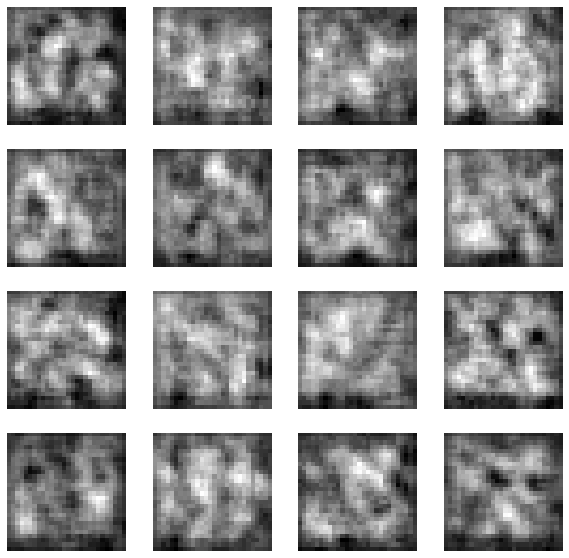

epoch : 100 생성자 손실 : 0.009 감별자 손실 : 0.019


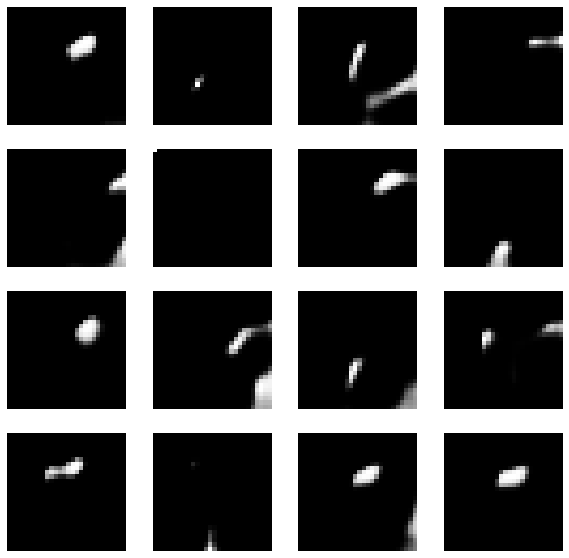

epoch : 200 생성자 손실 : 0.553 감별자 손실 : 0.071


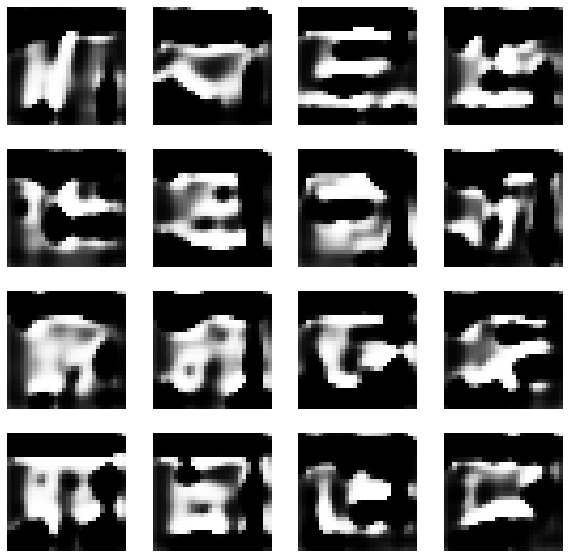

epoch : 300 생성자 손실 : 3.736 감별자 손실 : 0.232


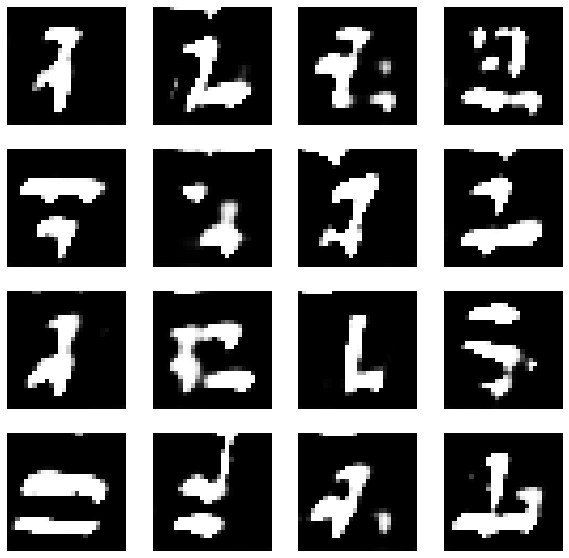

epoch : 400 생성자 손실 : 1.785 감별자 손실 : 0.126


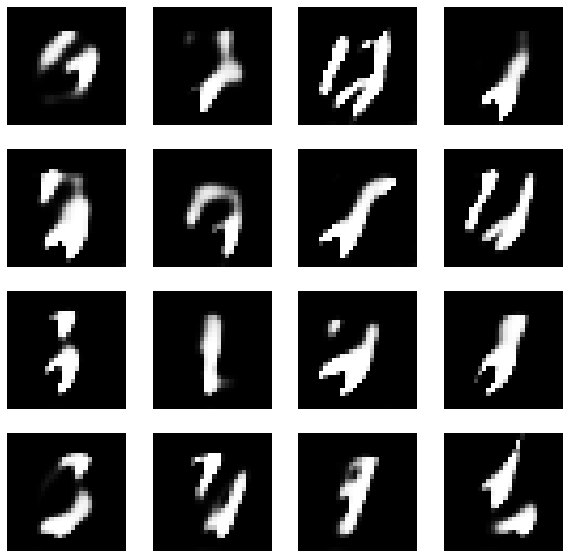

epoch : 500 생성자 손실 : 6.161 감별자 손실 : 0.150


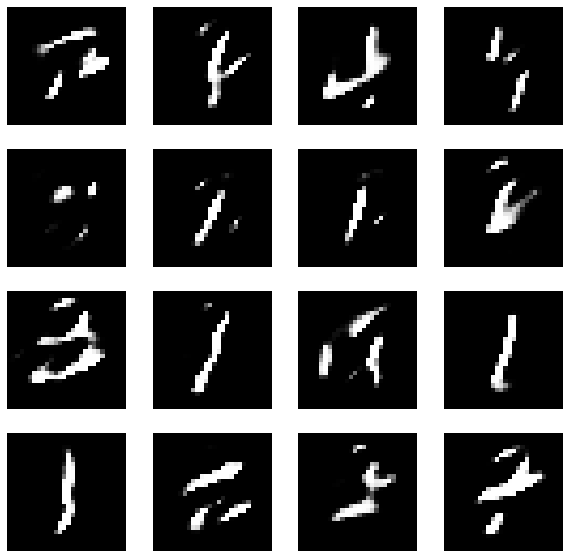

epoch : 600 생성자 손실 : 2.880 감별자 손실 : 0.239


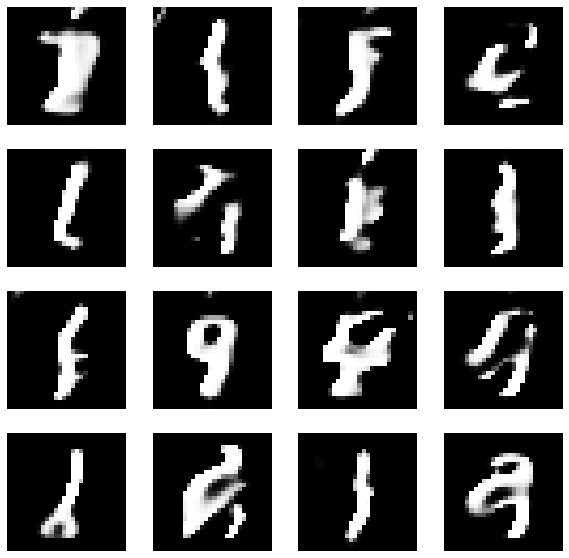

epoch : 700 생성자 손실 : 2.943 감별자 손실 : 0.300


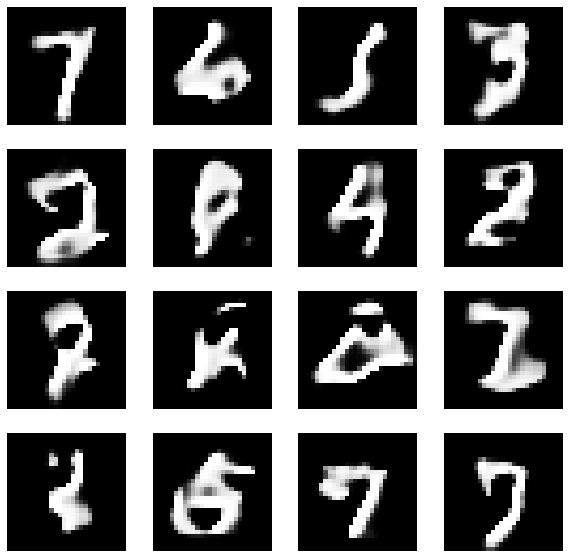

epoch : 800 생성자 손실 : 2.542 감별자 손실 : 0.297


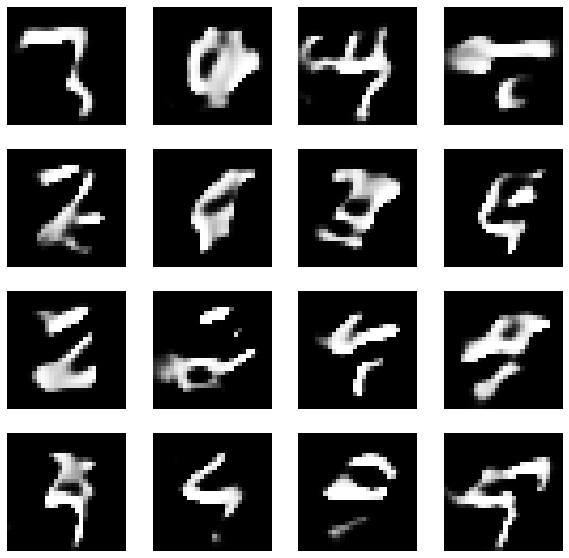

epoch : 900 생성자 손실 : 3.302 감별자 손실 : 0.227


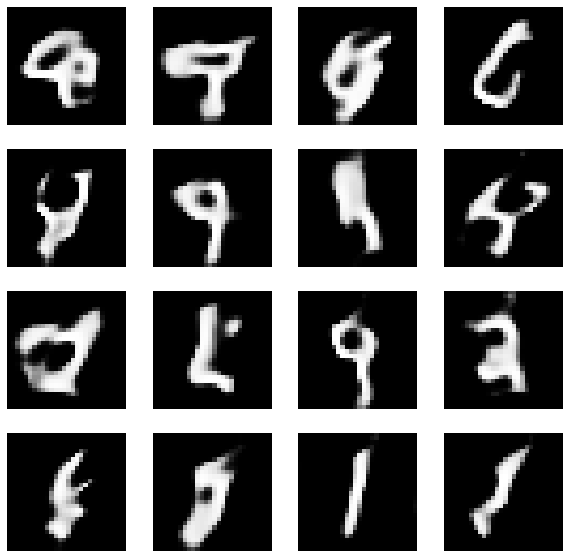

epoch : 1000 생성자 손실 : 2.859 감별자 손실 : 0.235


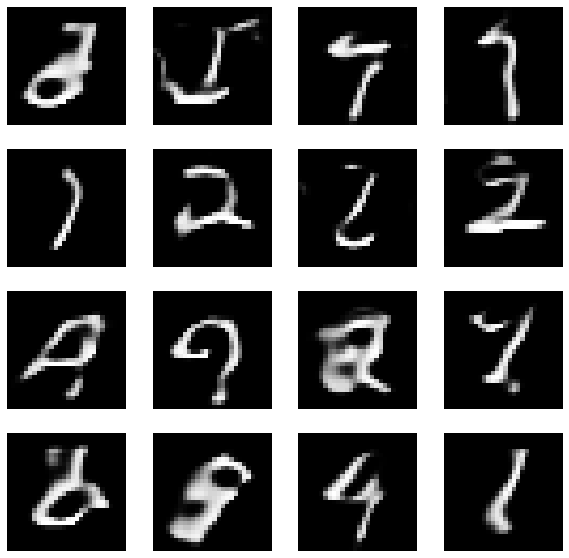

epoch : 1100 생성자 손실 : 2.260 감별자 손실 : 0.364


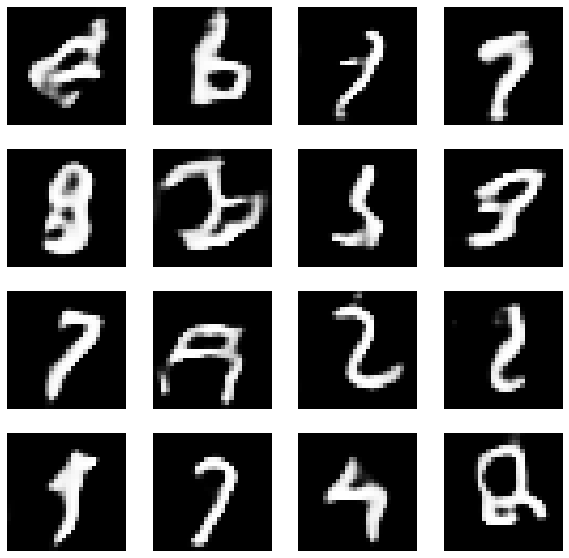

epoch : 1200 생성자 손실 : 2.224 감별자 손실 : 0.408


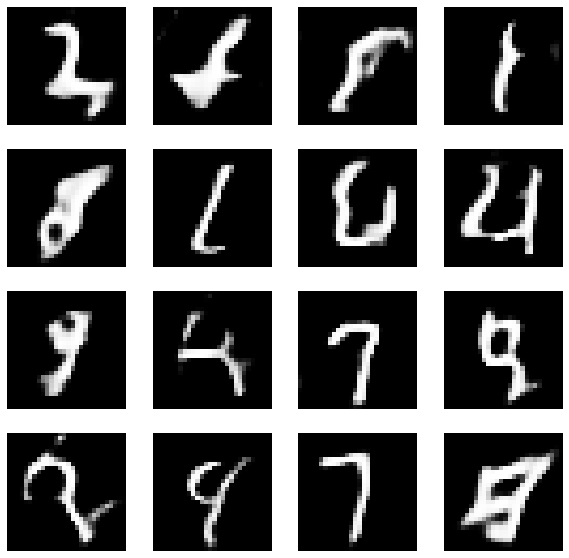

epoch : 1300 생성자 손실 : 1.955 감별자 손실 : 0.361


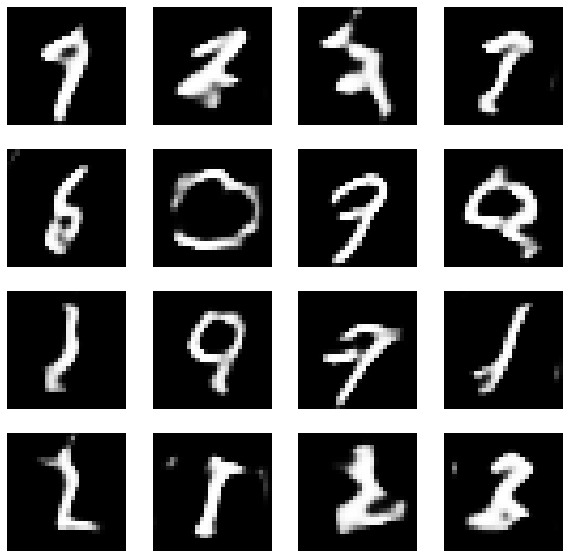

epoch : 1400 생성자 손실 : 2.165 감별자 손실 : 0.385


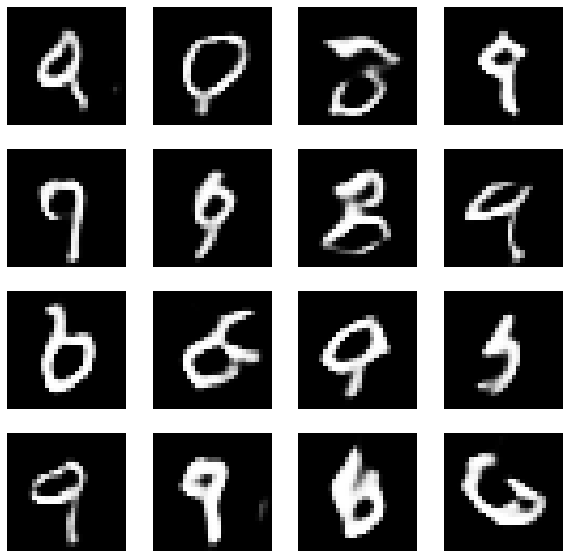

epoch : 1500 생성자 손실 : 1.808 감별자 손실 : 0.432


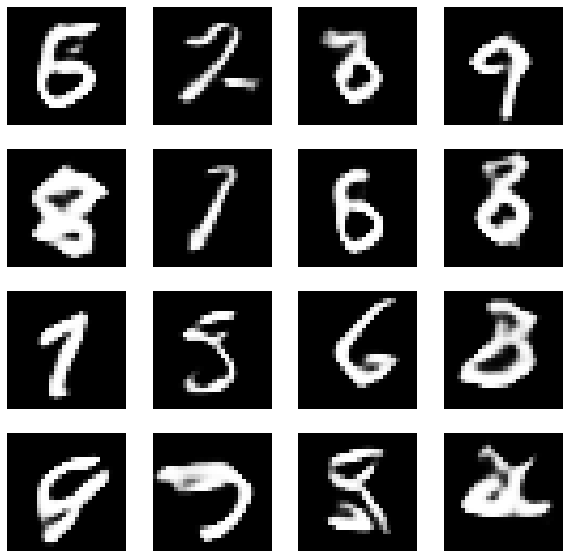

epoch : 1600 생성자 손실 : 1.843 감별자 손실 : 0.403


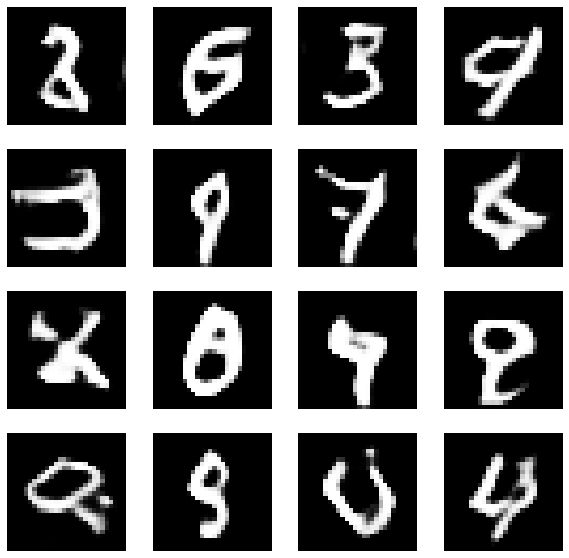

epoch : 1700 생성자 손실 : 1.722 감별자 손실 : 0.457


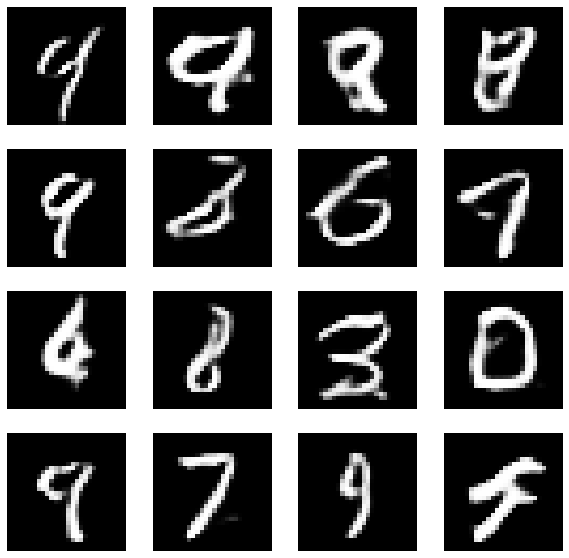

epoch : 1800 생성자 손실 : 1.990 감별자 손실 : 0.388


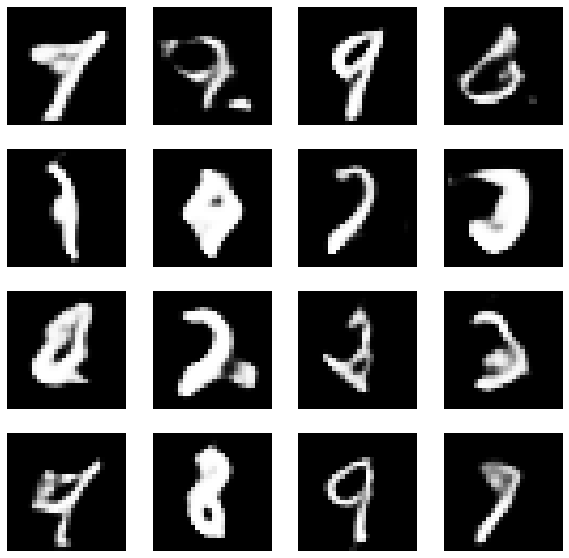

epoch : 1900 생성자 손실 : 1.790 감별자 손실 : 0.441


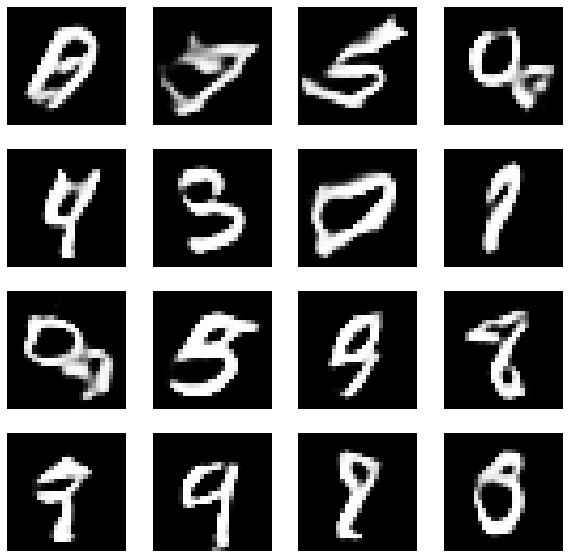

epoch : 2000 생성자 손실 : 1.945 감별자 손실 : 0.283


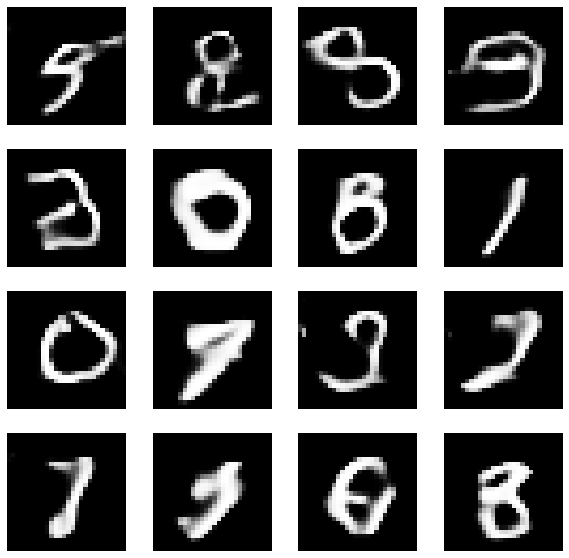

epoch : 2100 생성자 손실 : 1.618 감별자 손실 : 0.425


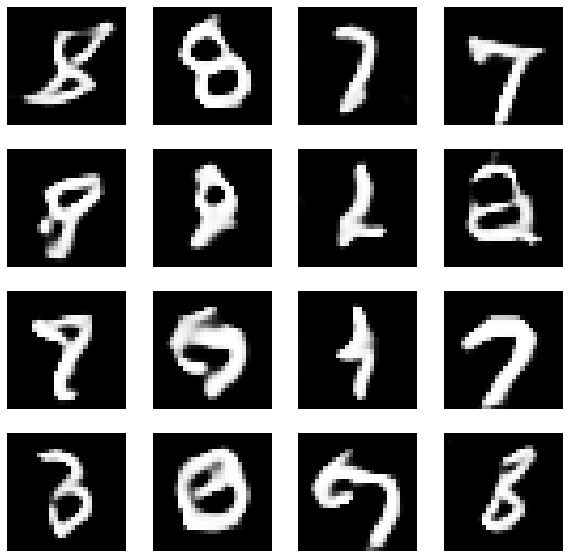

epoch : 2200 생성자 손실 : 2.091 감별자 손실 : 0.425


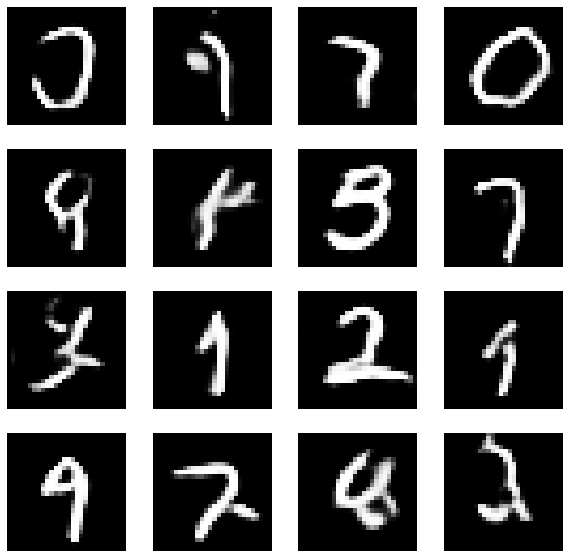

epoch : 2300 생성자 손실 : 1.487 감별자 손실 : 0.524


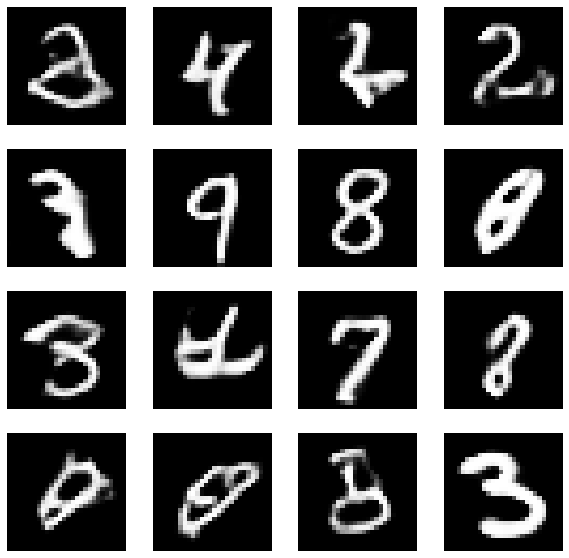

epoch : 2400 생성자 손실 : 1.587 감별자 손실 : 0.488


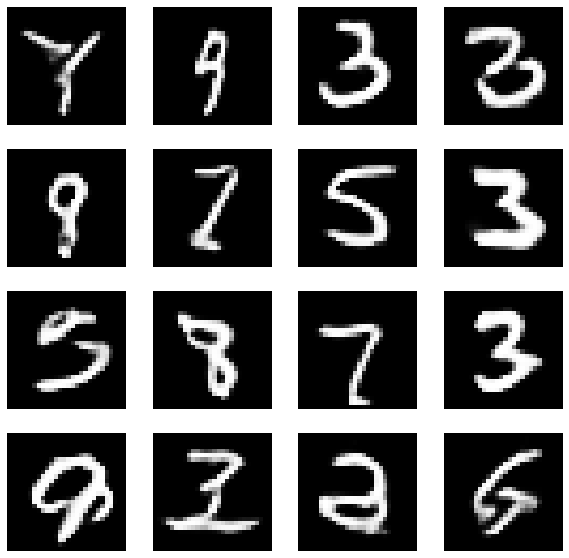

epoch : 2500 생성자 손실 : 1.751 감별자 손실 : 0.478


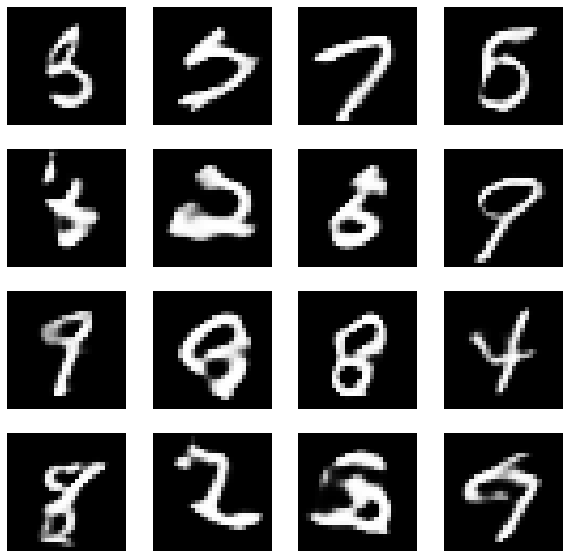

epoch : 2600 생성자 손실 : 1.822 감별자 손실 : 0.391


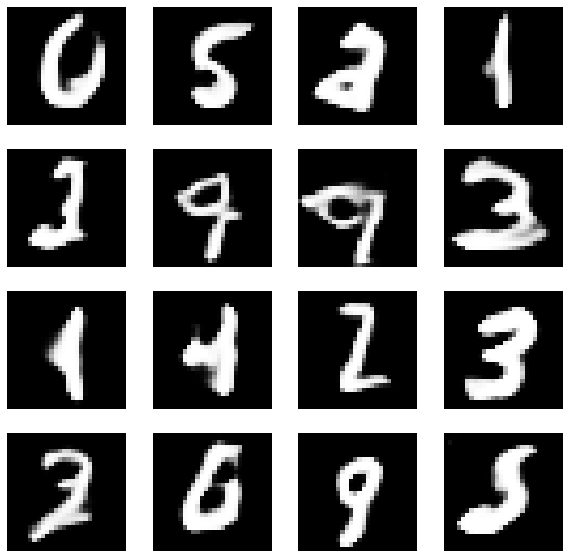

epoch : 2700 생성자 손실 : 1.518 감별자 손실 : 0.452


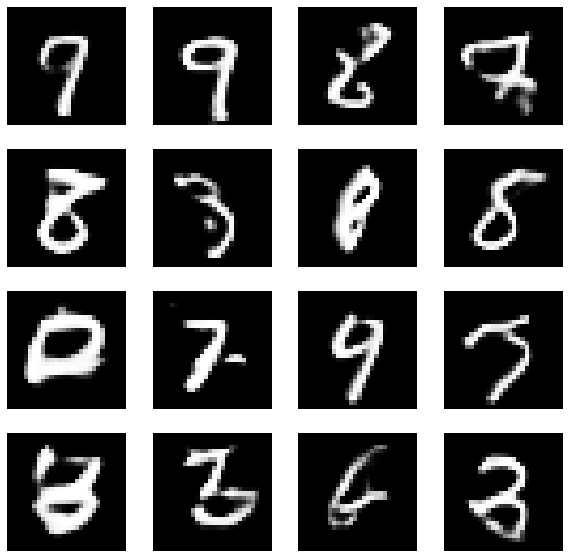

epoch : 2800 생성자 손실 : 1.444 감별자 손실 : 0.482


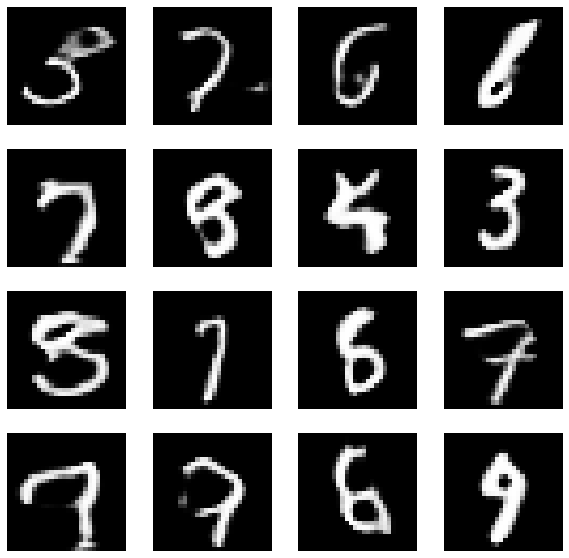

epoch : 2900 생성자 손실 : 1.601 감별자 손실 : 0.505


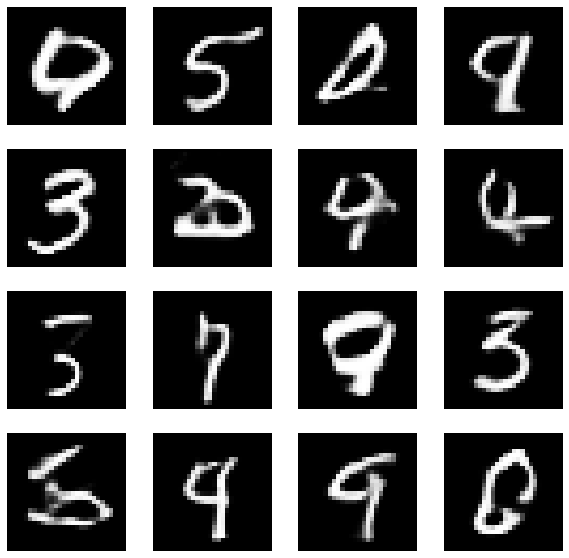

epoch : 3000 생성자 손실 : 1.656 감별자 손실 : 0.472


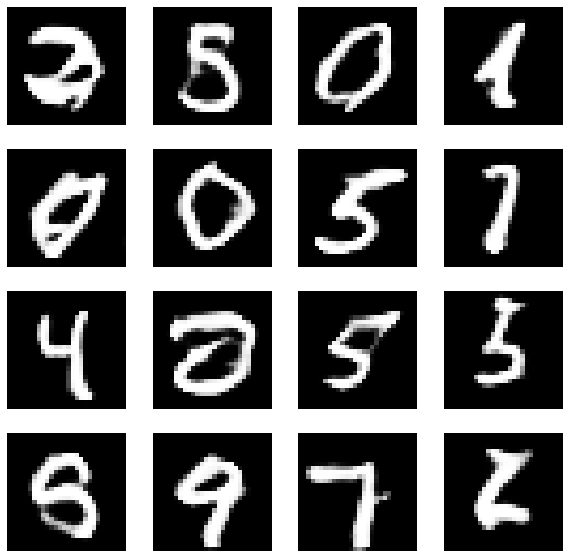

epoch : 3100 생성자 손실 : 1.205 감별자 손실 : 0.542


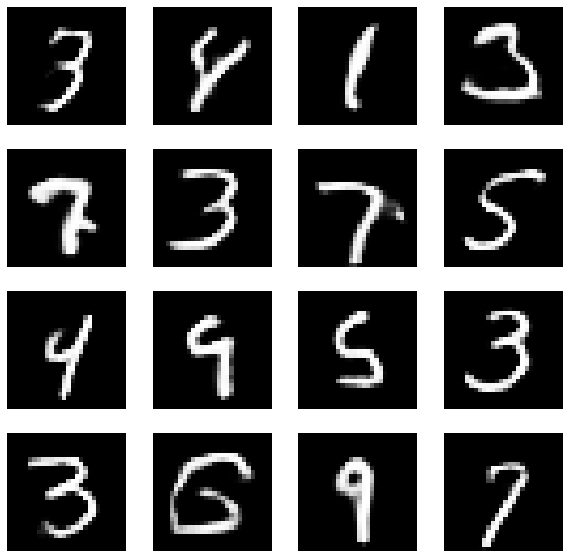

epoch : 3200 생성자 손실 : 1.515 감별자 손실 : 0.485


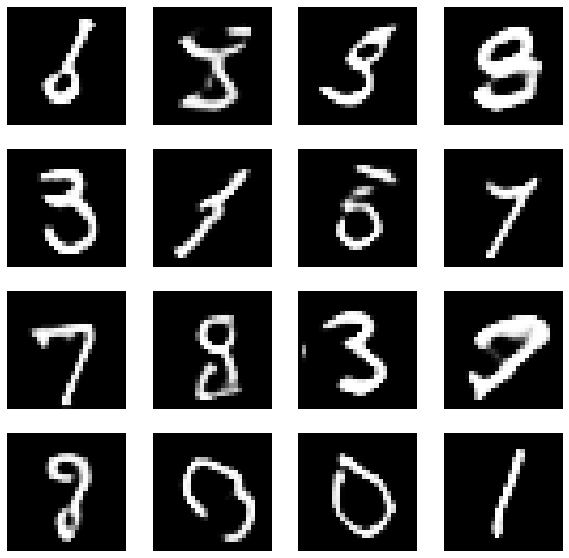

epoch : 3300 생성자 손실 : 1.778 감별자 손실 : 0.514


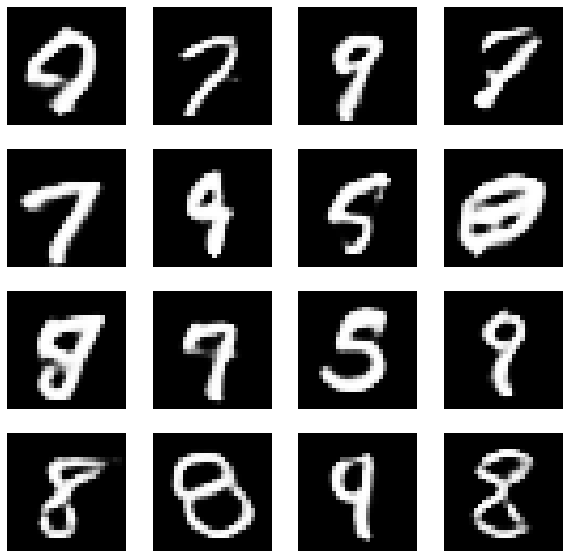

epoch : 3400 생성자 손실 : 1.985 감별자 손실 : 0.452


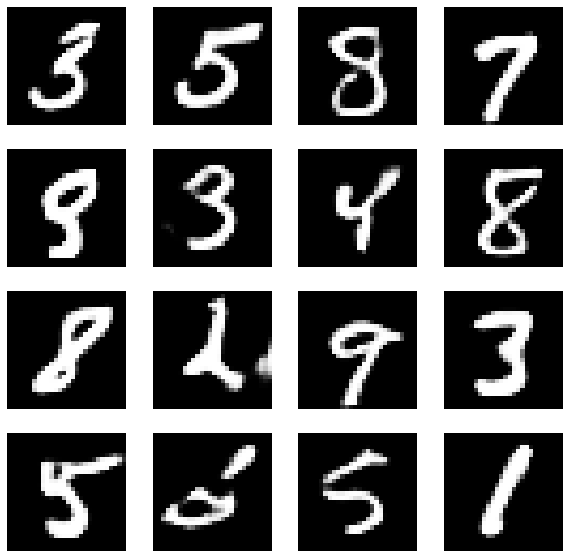

epoch : 3500 생성자 손실 : 1.205 감별자 손실 : 0.590


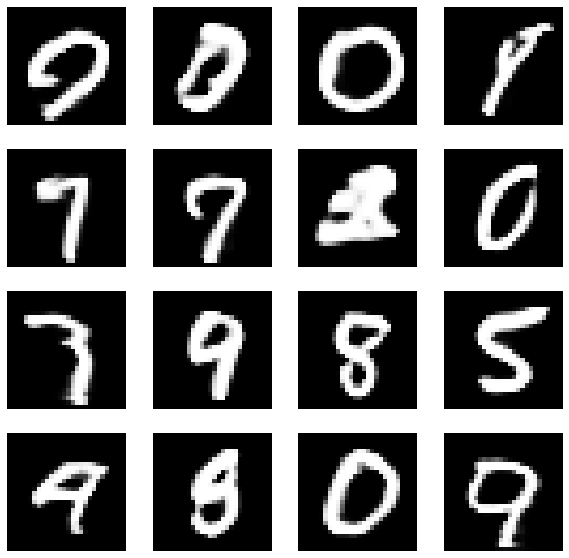

epoch : 3600 생성자 손실 : 1.307 감별자 손실 : 0.523


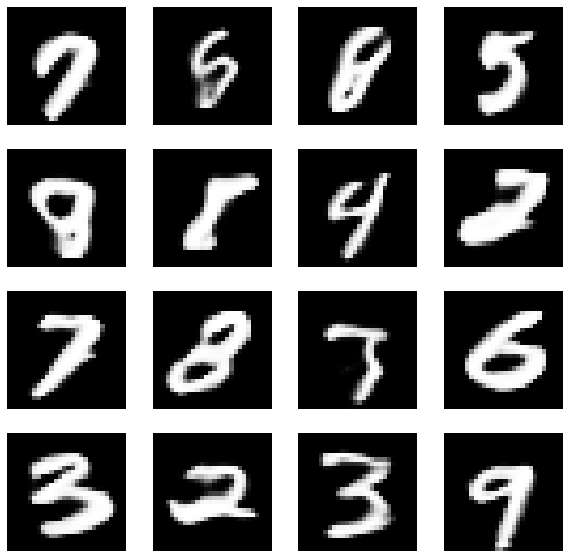

epoch : 3700 생성자 손실 : 1.696 감별자 손실 : 0.433


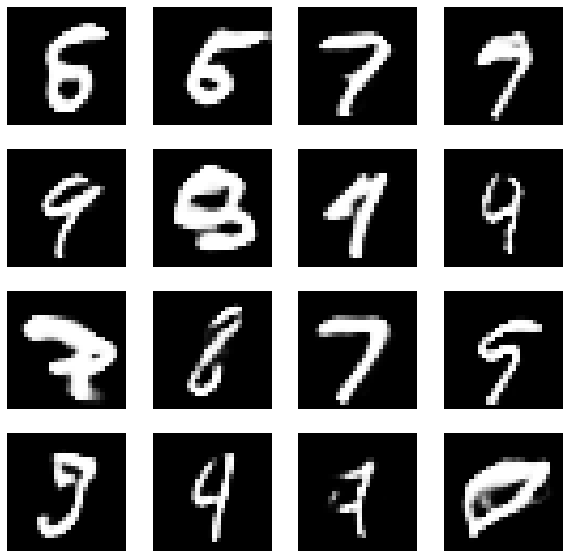

epoch : 3800 생성자 손실 : 1.701 감별자 손실 : 0.445


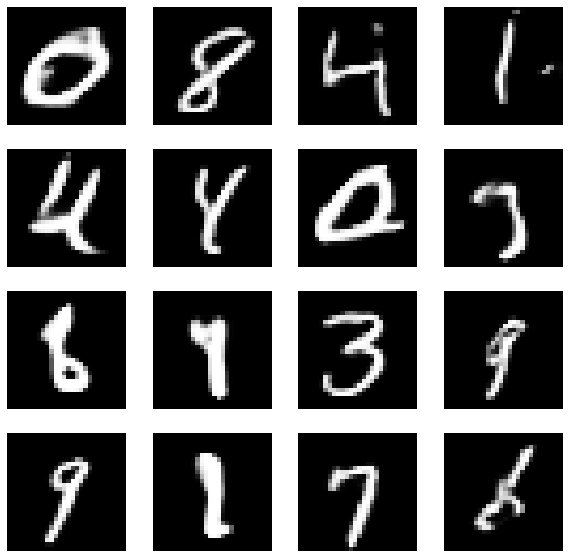

epoch : 3900 생성자 손실 : 1.307 감별자 손실 : 0.564


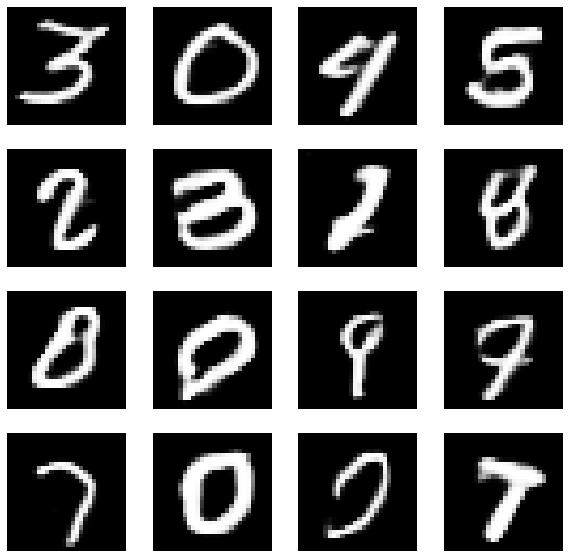

epoch : 4000 생성자 손실 : 1.418 감별자 손실 : 0.502


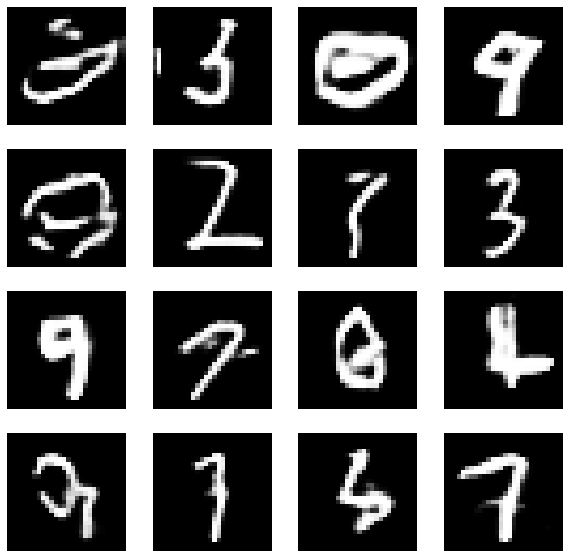

epoch : 4100 생성자 손실 : 1.615 감별자 손실 : 0.476


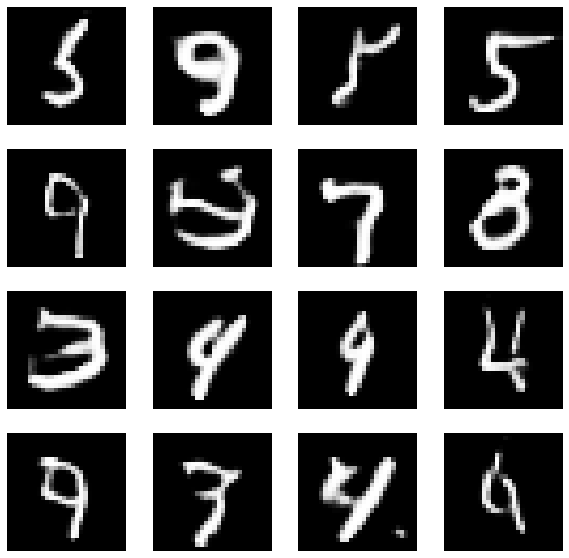

epoch : 4200 생성자 손실 : 1.557 감별자 손실 : 0.475


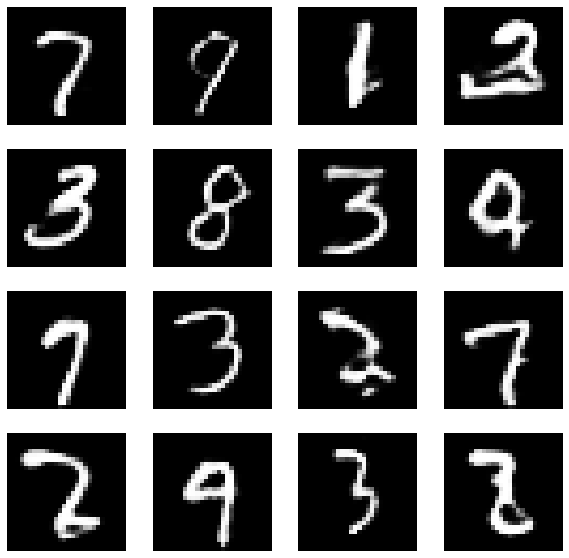

epoch : 4300 생성자 손실 : 1.177 감별자 손실 : 0.501


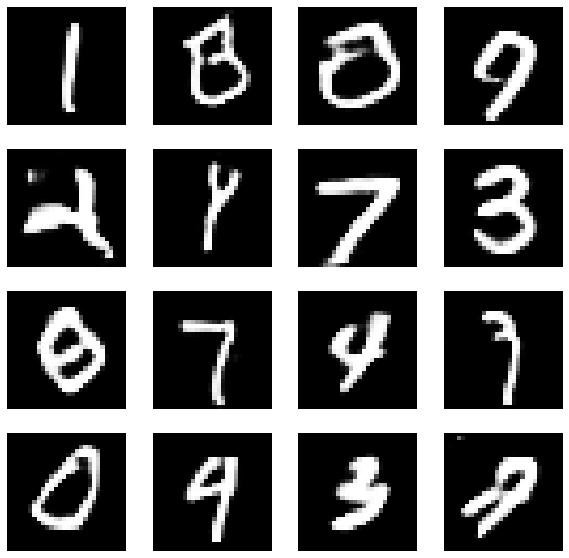

epoch : 4400 생성자 손실 : 1.833 감별자 손실 : 0.437


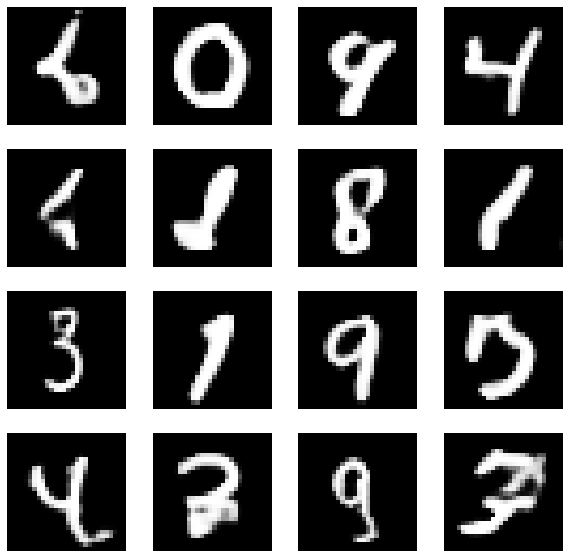

epoch : 4500 생성자 손실 : 1.903 감별자 손실 : 0.403


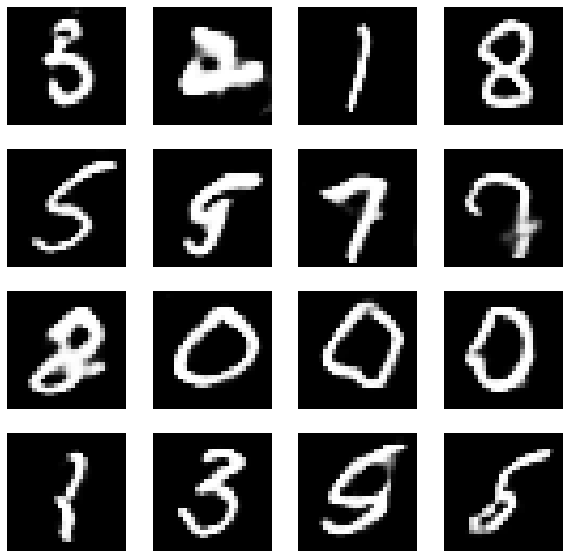

epoch : 4600 생성자 손실 : 1.475 감별자 손실 : 0.485


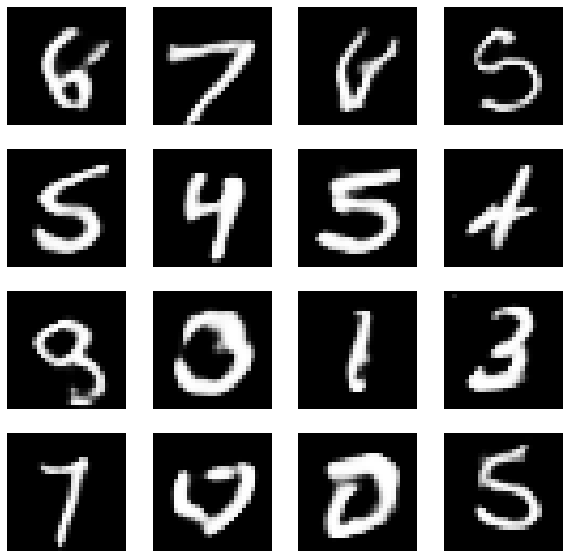

epoch : 4700 생성자 손실 : 1.582 감별자 손실 : 0.520


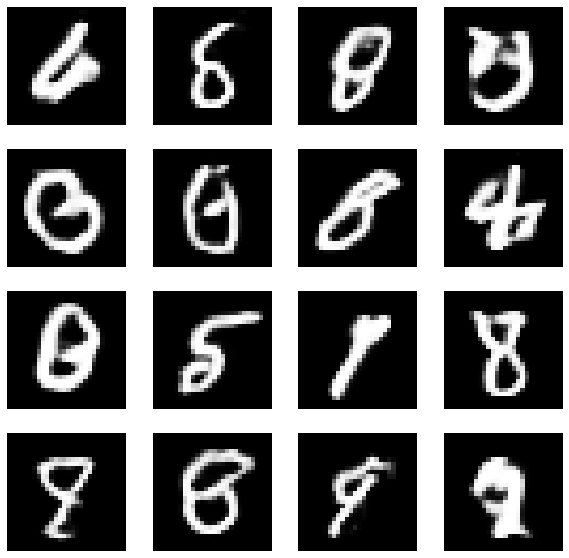

epoch : 4800 생성자 손실 : 1.408 감별자 손실 : 0.526


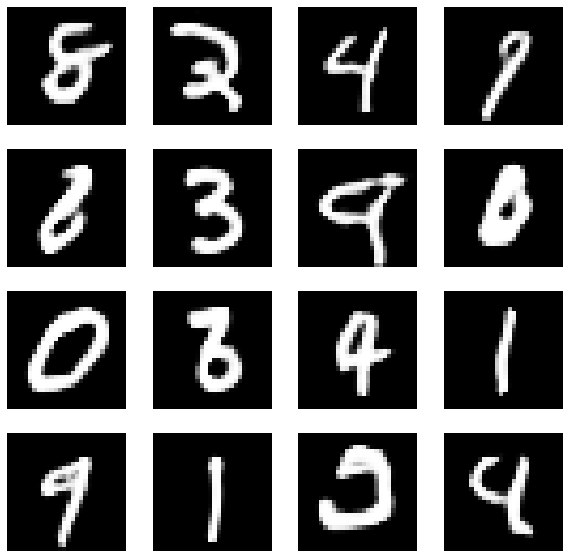

epoch : 4900 생성자 손실 : 1.686 감별자 손실 : 0.431


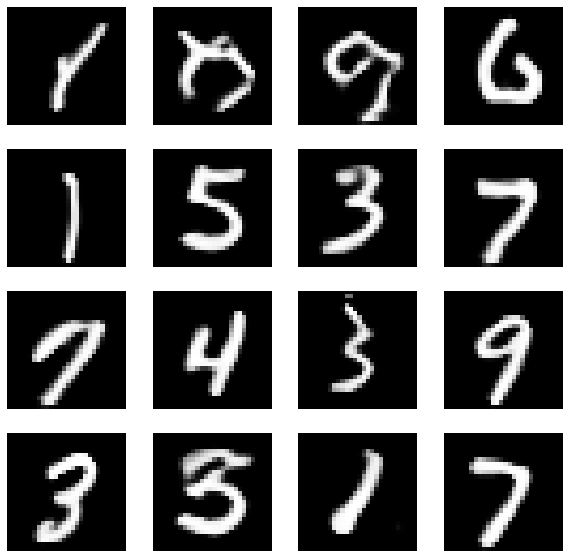

epoch : 5000 생성자 손실 : 1.287 감별자 손실 : 0.562


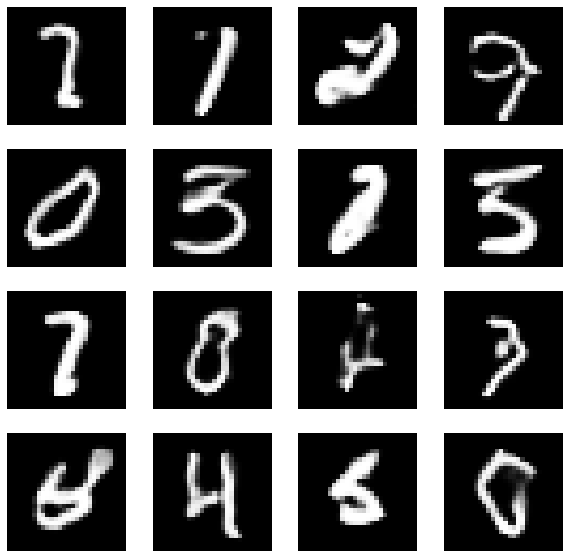

epoch : 5100 생성자 손실 : 1.418 감별자 손실 : 0.557


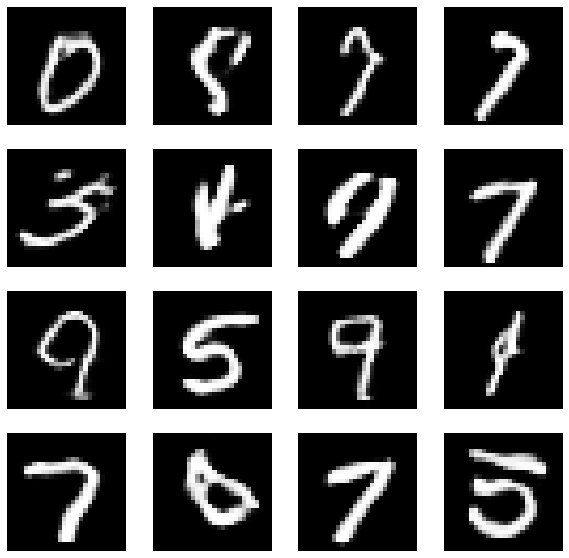

epoch : 5200 생성자 손실 : 1.516 감별자 손실 : 0.460


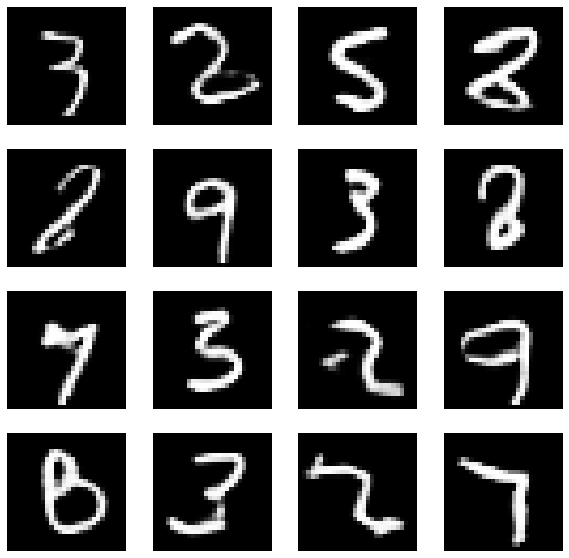

epoch : 5300 생성자 손실 : 1.575 감별자 손실 : 0.489


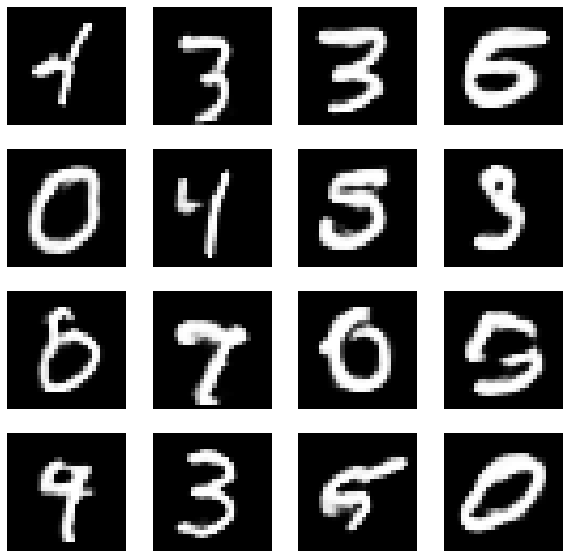

epoch : 5400 생성자 손실 : 1.415 감별자 손실 : 0.513


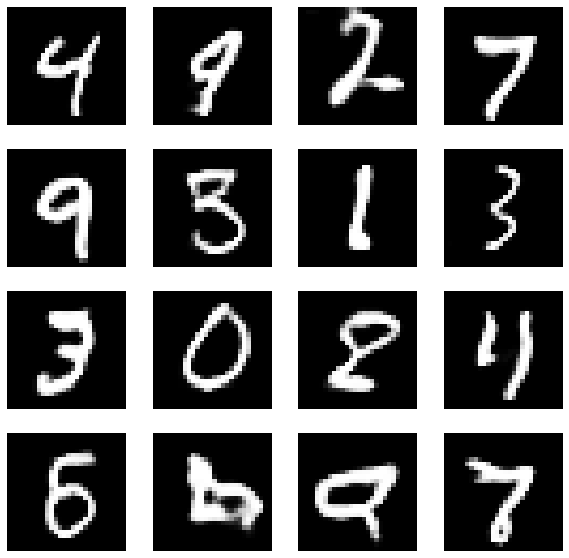

epoch : 5500 생성자 손실 : 1.767 감별자 손실 : 0.395


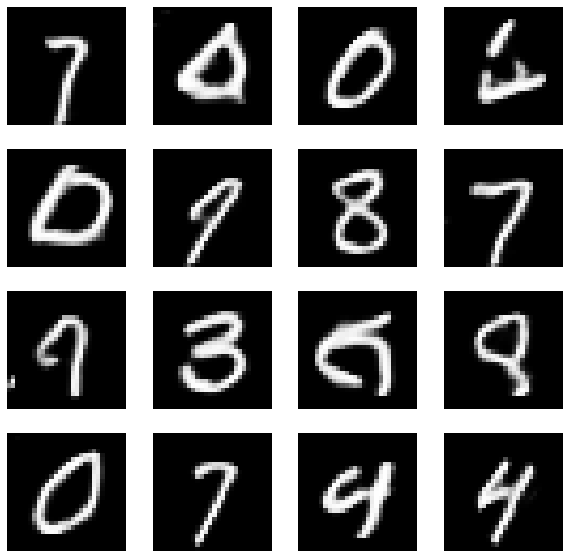

epoch : 5600 생성자 손실 : 1.368 감별자 손실 : 0.589


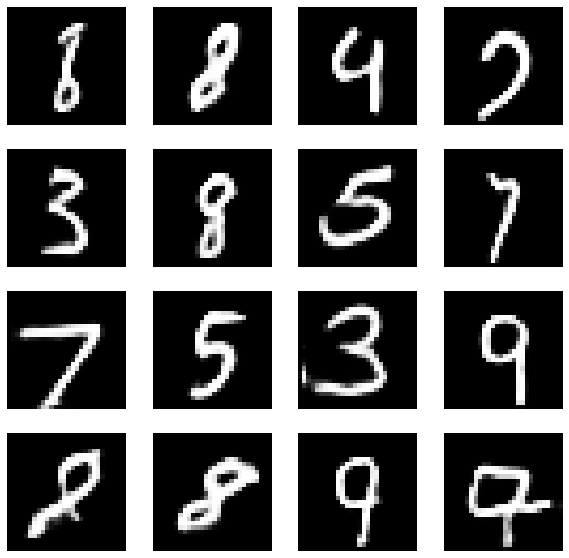

epoch : 5700 생성자 손실 : 1.636 감별자 손실 : 0.494


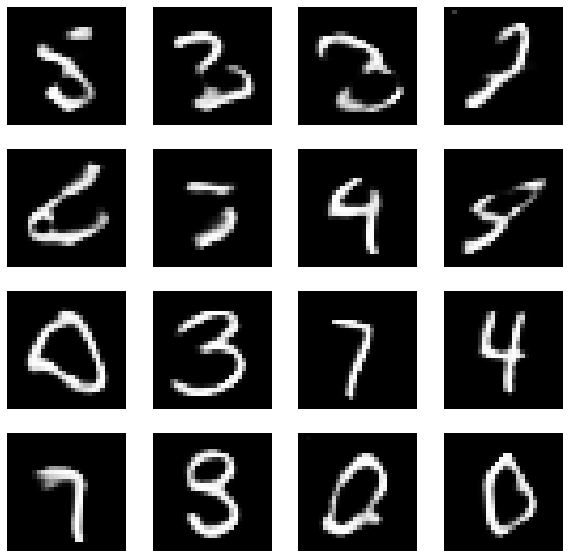

epoch : 5800 생성자 손실 : 1.422 감별자 손실 : 0.519


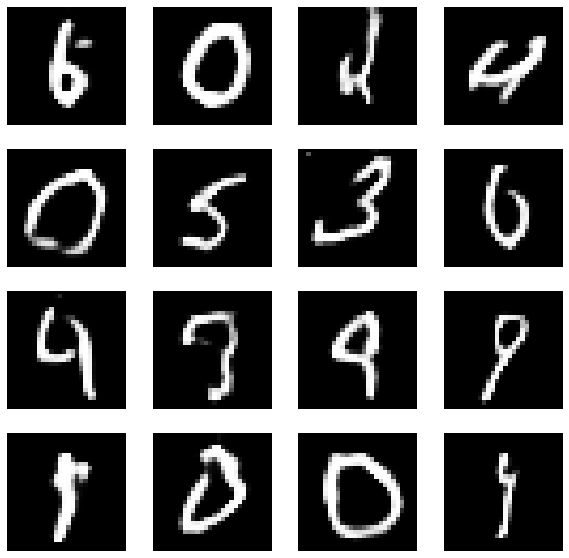

epoch : 5900 생성자 손실 : 1.483 감별자 손실 : 0.536


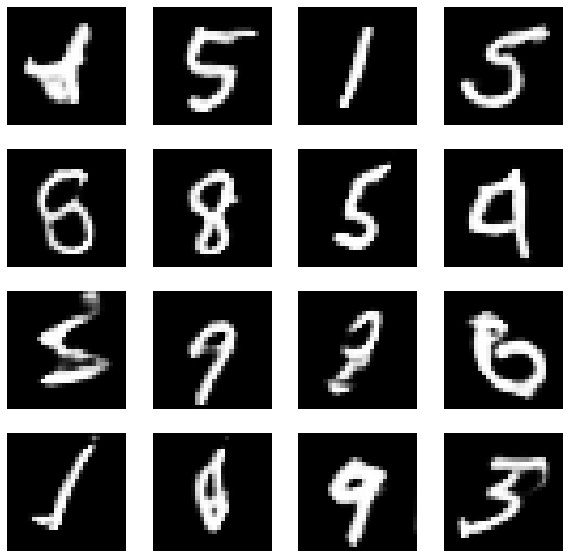

epoch : 6000 생성자 손실 : 1.496 감별자 손실 : 0.487


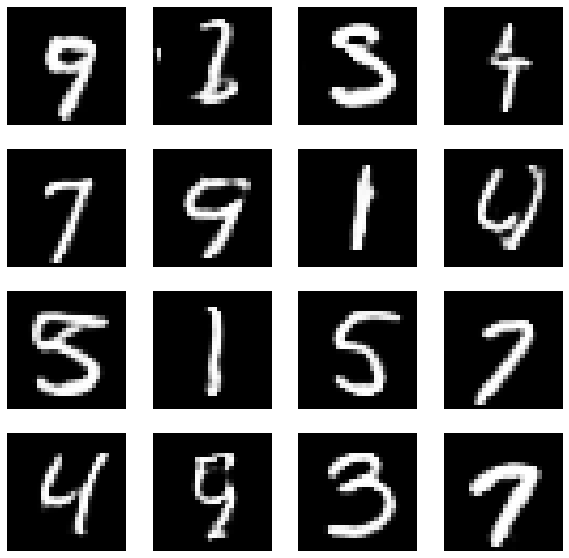

epoch : 6100 생성자 손실 : 1.450 감별자 손실 : 0.544


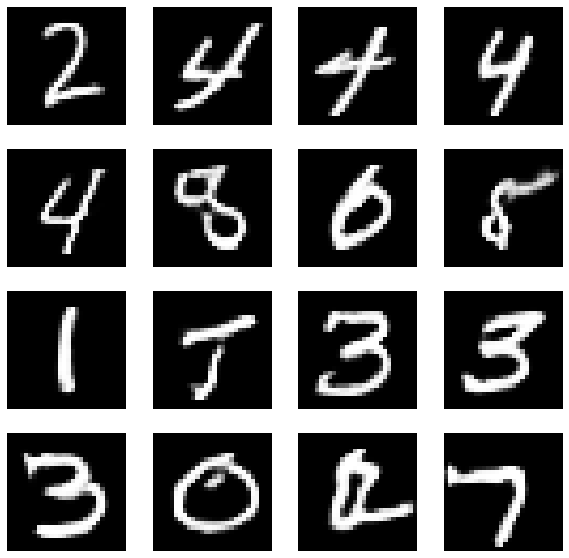

epoch : 6200 생성자 손실 : 1.387 감별자 손실 : 0.519


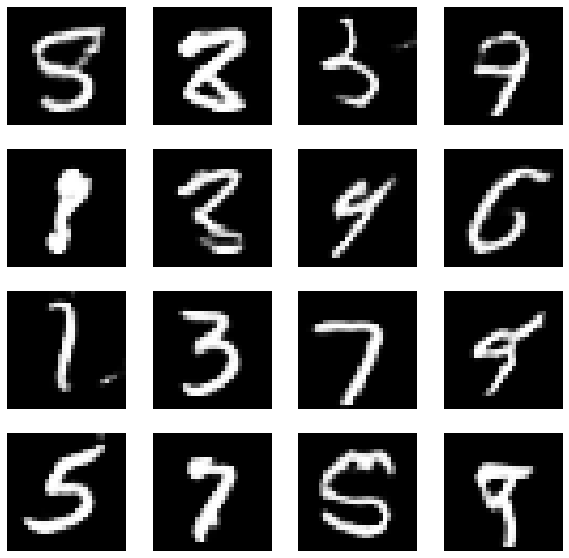

epoch : 6300 생성자 손실 : 1.491 감별자 손실 : 0.494


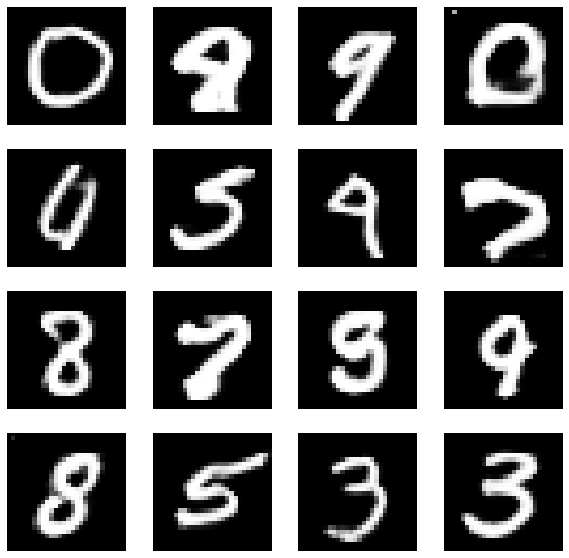

epoch : 6400 생성자 손실 : 1.284 감별자 손실 : 0.510


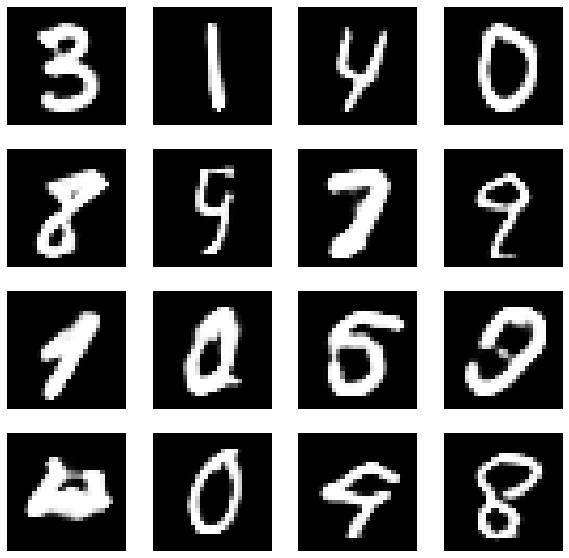

epoch : 6500 생성자 손실 : 1.464 감별자 손실 : 0.529


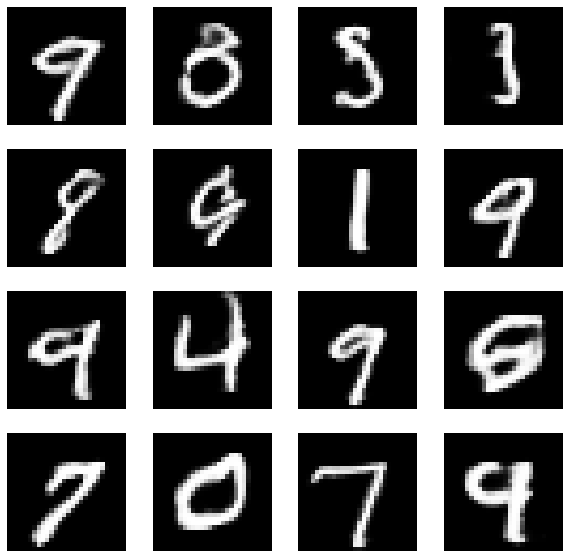

epoch : 6600 생성자 손실 : 1.830 감별자 손실 : 0.332


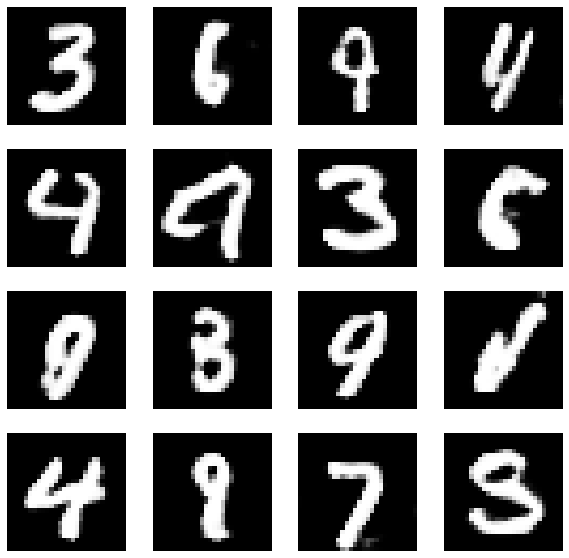

epoch : 6700 생성자 손실 : 1.387 감별자 손실 : 0.489


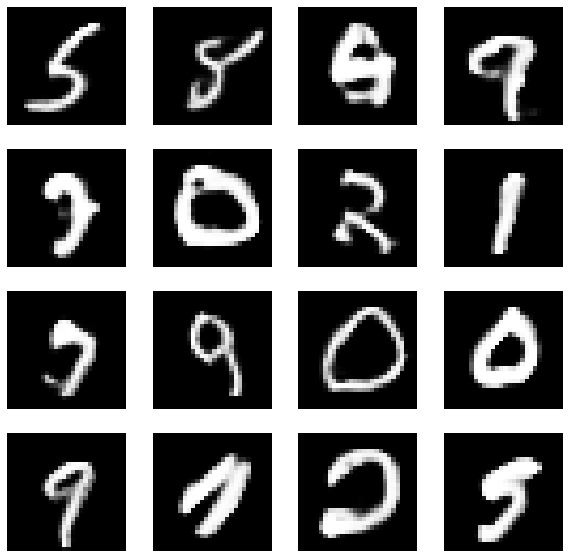

epoch : 6800 생성자 손실 : 1.263 감별자 손실 : 0.561


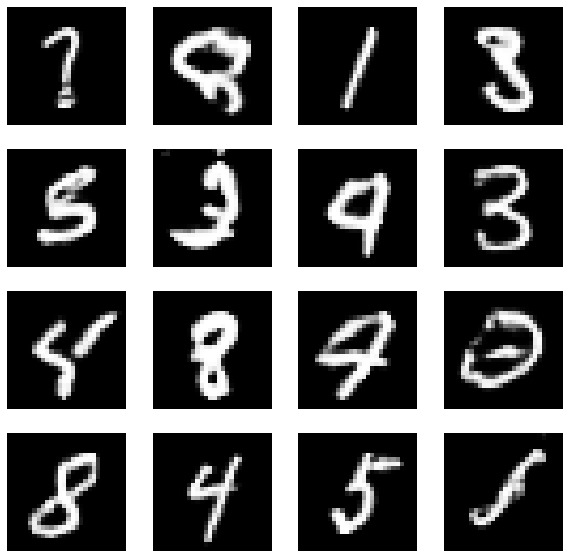

epoch : 6900 생성자 손실 : 1.315 감별자 손실 : 0.566


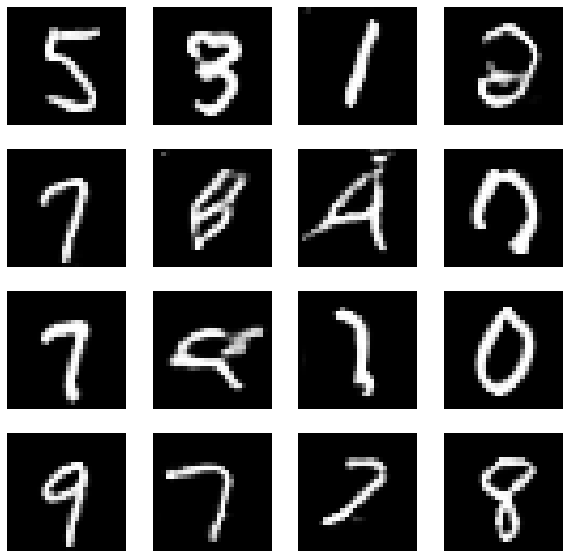

epoch : 7000 생성자 손실 : 1.376 감별자 손실 : 0.501


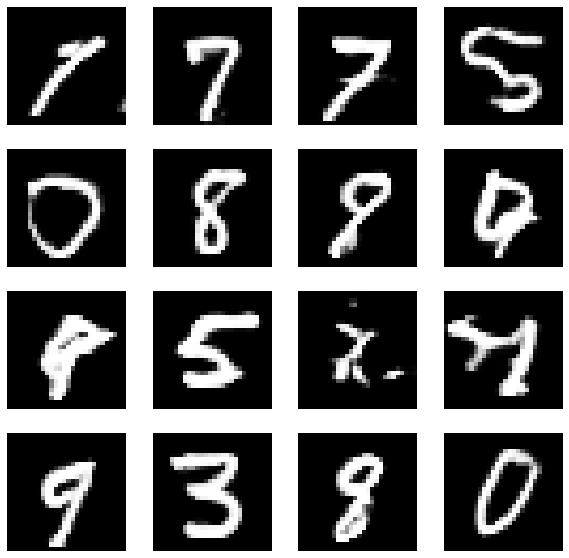

epoch : 7100 생성자 손실 : 1.299 감별자 손실 : 0.564


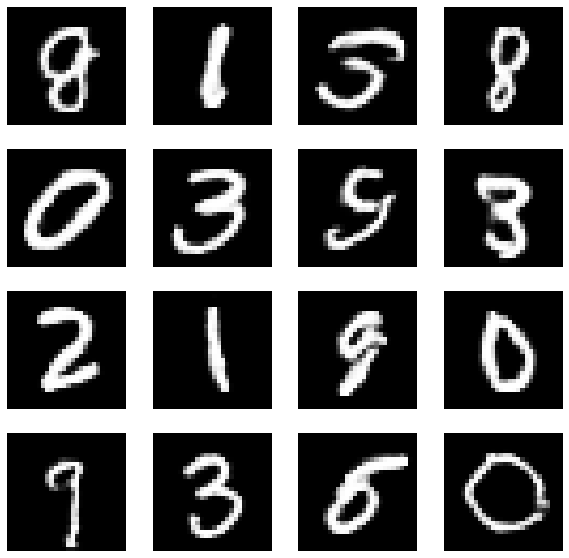

epoch : 7200 생성자 손실 : 1.282 감별자 손실 : 0.537


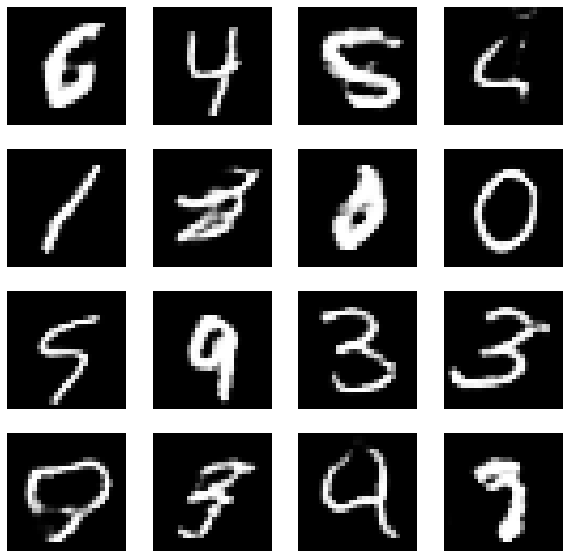

epoch : 7300 생성자 손실 : 1.315 감별자 손실 : 0.542


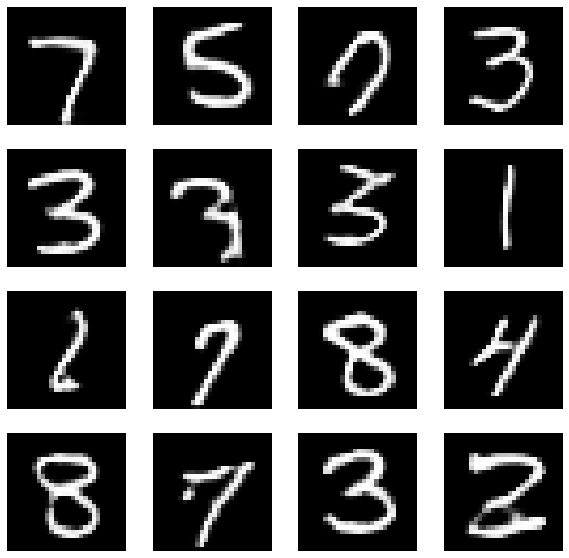

epoch : 7400 생성자 손실 : 1.255 감별자 손실 : 0.515


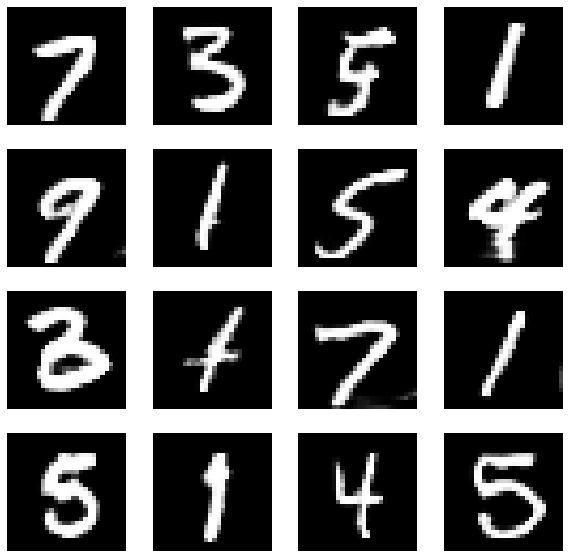

epoch : 7500 생성자 손실 : 1.386 감별자 손실 : 0.496


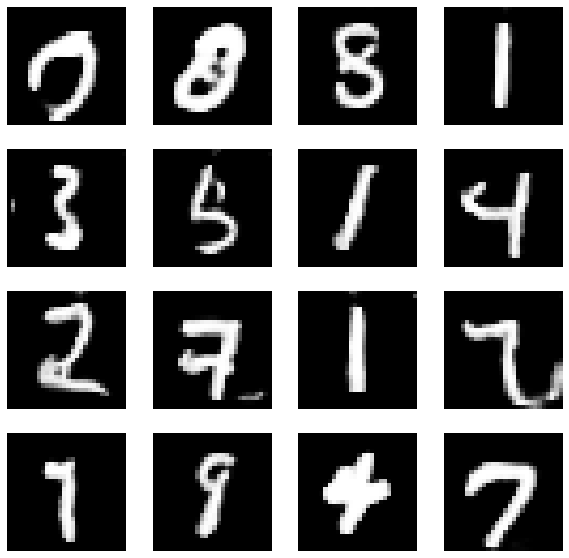

epoch : 7600 생성자 손실 : 1.264 감별자 손실 : 0.495


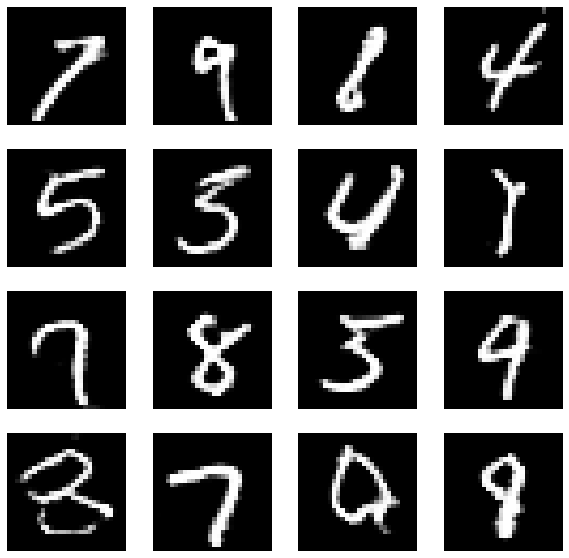

epoch : 7700 생성자 손실 : 1.629 감별자 손실 : 0.483


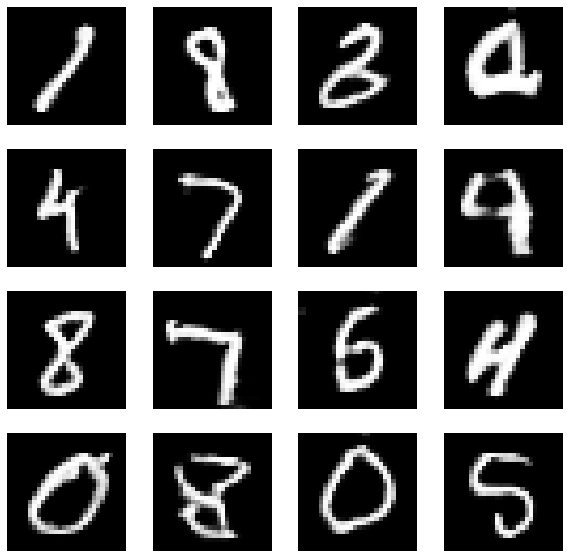

epoch : 7800 생성자 손실 : 1.329 감별자 손실 : 0.519


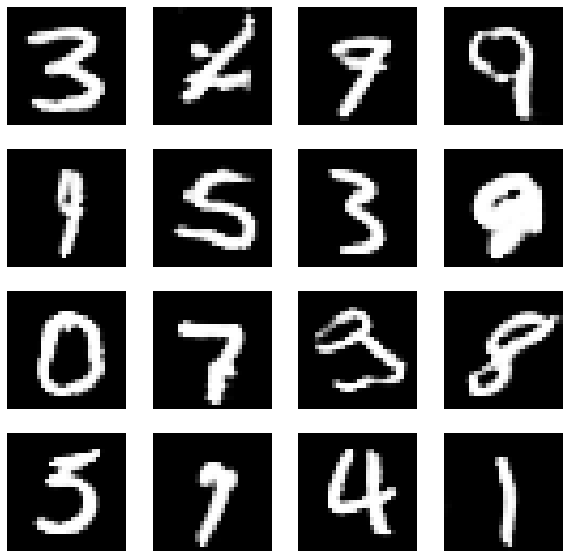

epoch : 7900 생성자 손실 : 1.416 감별자 손실 : 0.530


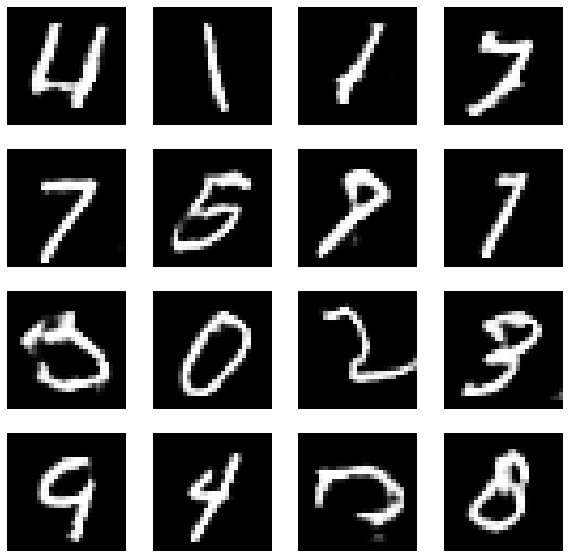

epoch : 8000 생성자 손실 : 1.103 감별자 손실 : 0.584


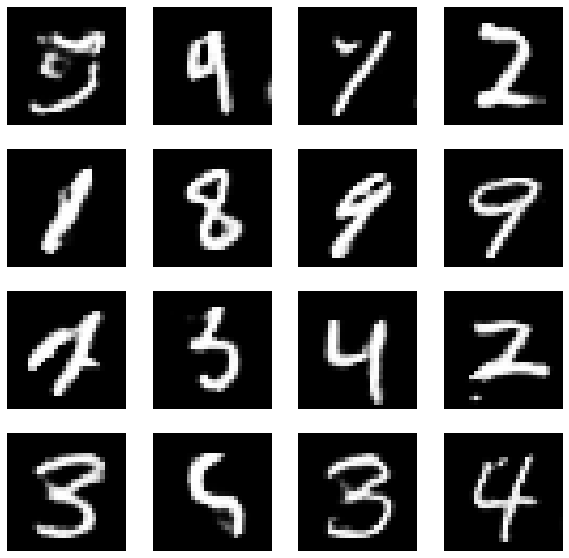

epoch : 8100 생성자 손실 : 1.148 감별자 손실 : 0.554


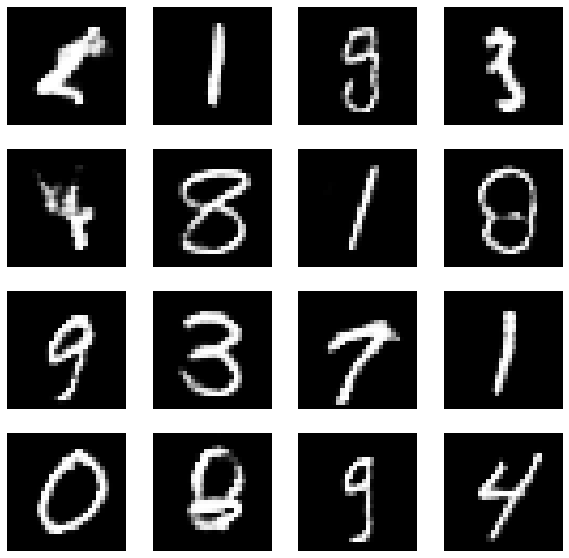

epoch : 8200 생성자 손실 : 1.527 감별자 손실 : 0.501


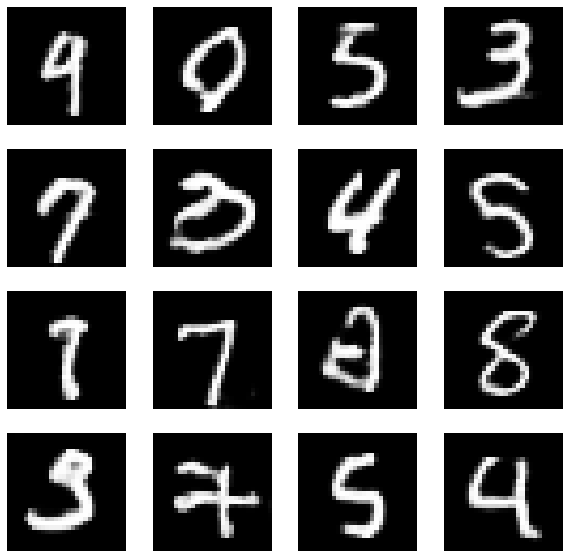

epoch : 8300 생성자 손실 : 1.342 감별자 손실 : 0.510


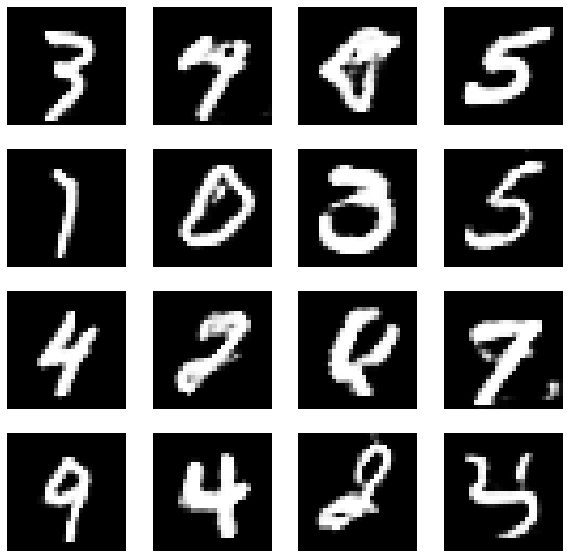

epoch : 8400 생성자 손실 : 1.272 감별자 손실 : 0.553


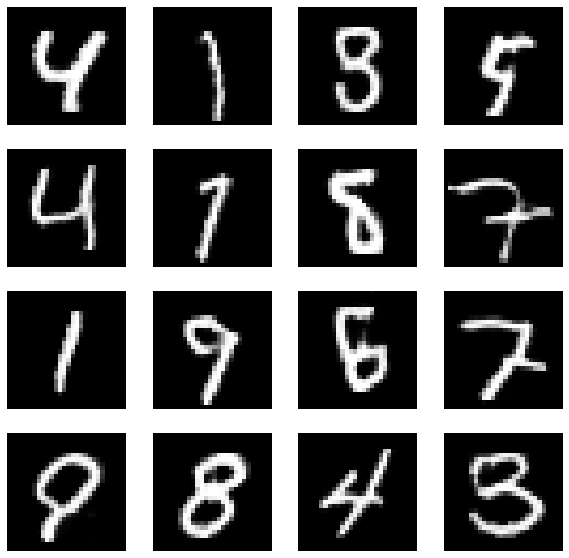

epoch : 8500 생성자 손실 : 1.213 감별자 손실 : 0.556


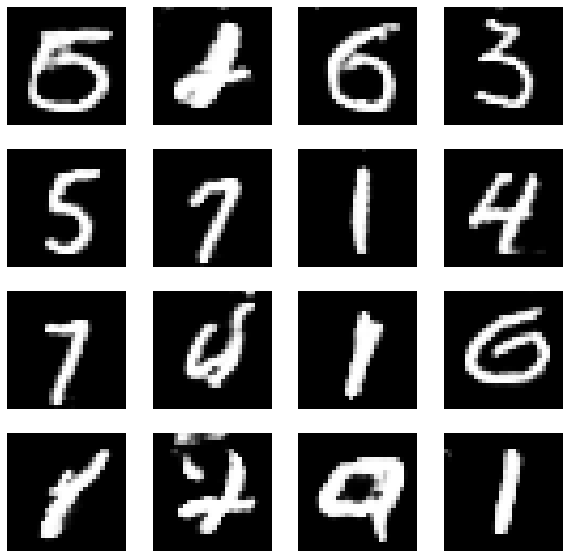

epoch : 8600 생성자 손실 : 1.268 감별자 손실 : 0.590


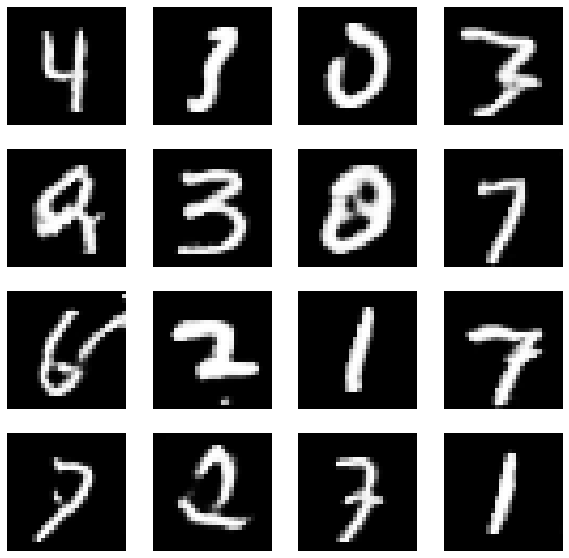

epoch : 8700 생성자 손실 : 1.207 감별자 손실 : 0.521


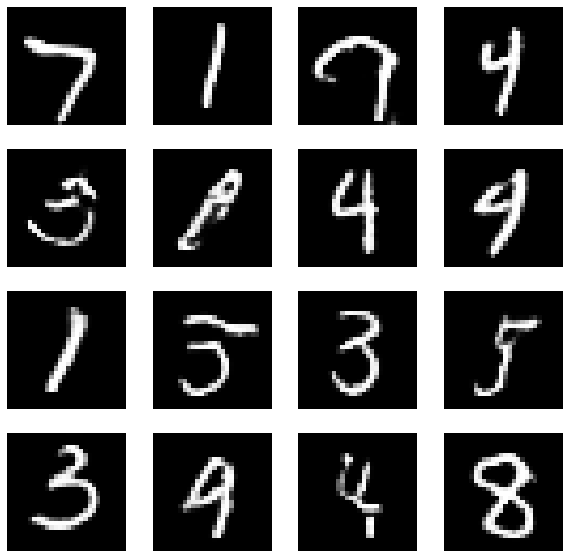

epoch : 8800 생성자 손실 : 1.077 감별자 손실 : 0.590


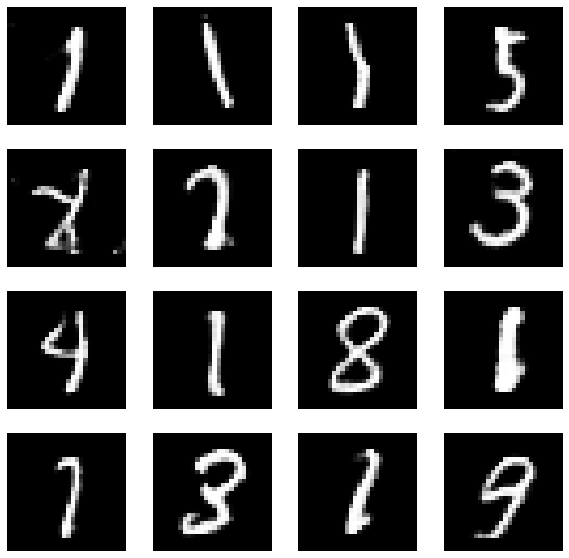

epoch : 8900 생성자 손실 : 1.295 감별자 손실 : 0.550


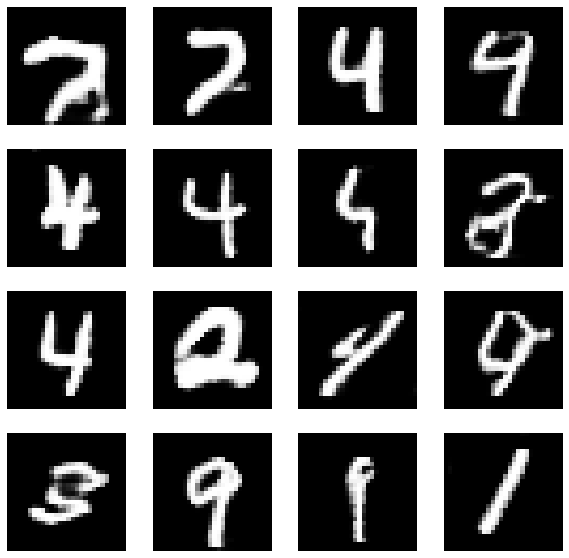

epoch : 9000 생성자 손실 : 1.353 감별자 손실 : 0.539


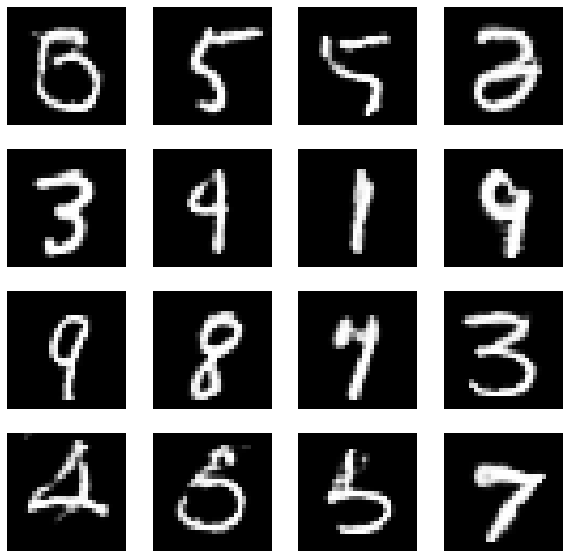

epoch : 9100 생성자 손실 : 1.318 감별자 손실 : 0.504


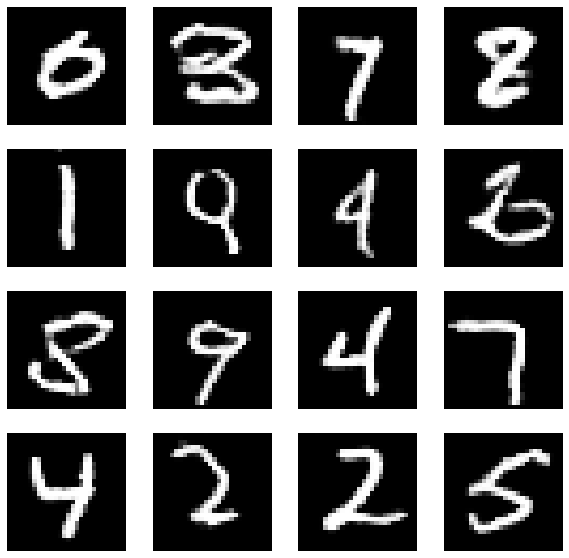

epoch : 9200 생성자 손실 : 1.168 감별자 손실 : 0.577


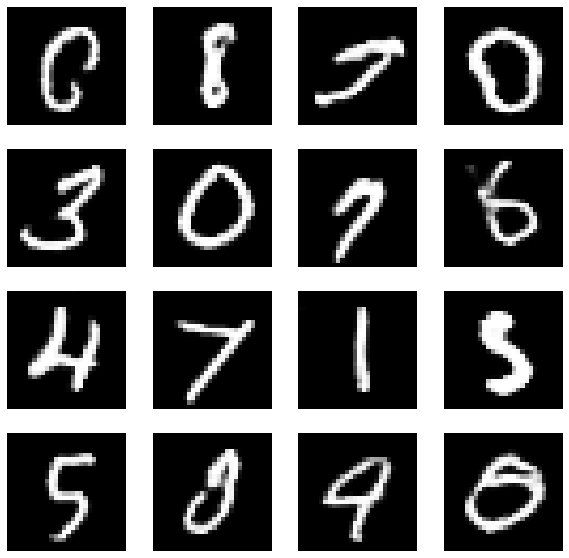

epoch : 9300 생성자 손실 : 1.318 감별자 손실 : 0.493


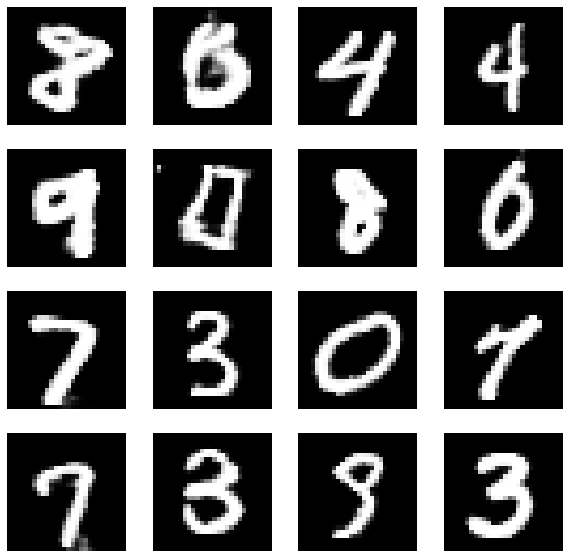

epoch : 9400 생성자 손실 : 1.627 감별자 손실 : 0.525


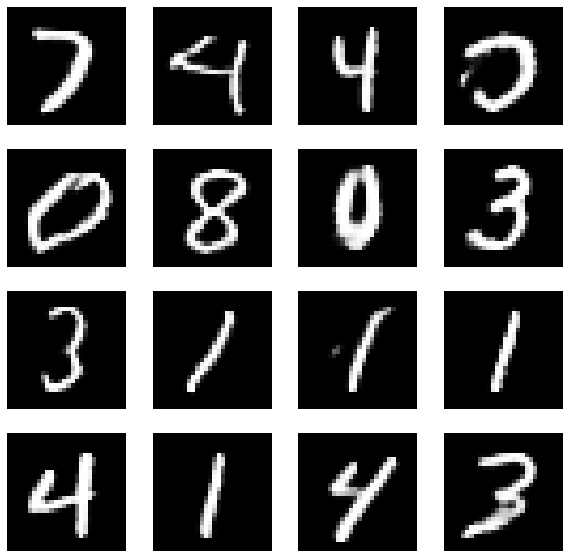

epoch : 9500 생성자 손실 : 1.464 감별자 손실 : 0.515


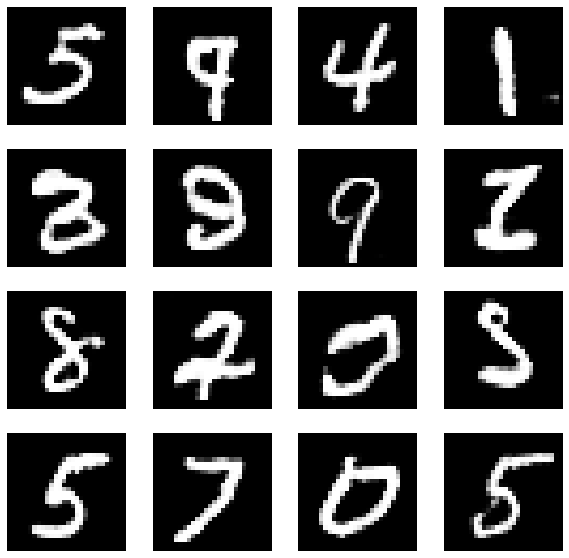

epoch : 9600 생성자 손실 : 1.290 감별자 손실 : 0.539


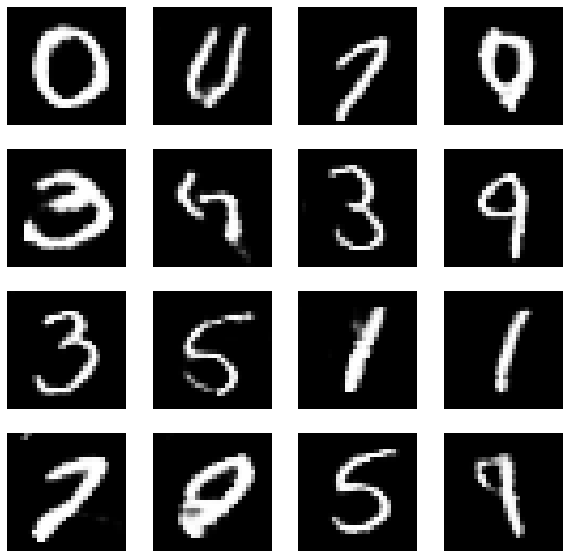

epoch : 9700 생성자 손실 : 1.223 감별자 손실 : 0.542


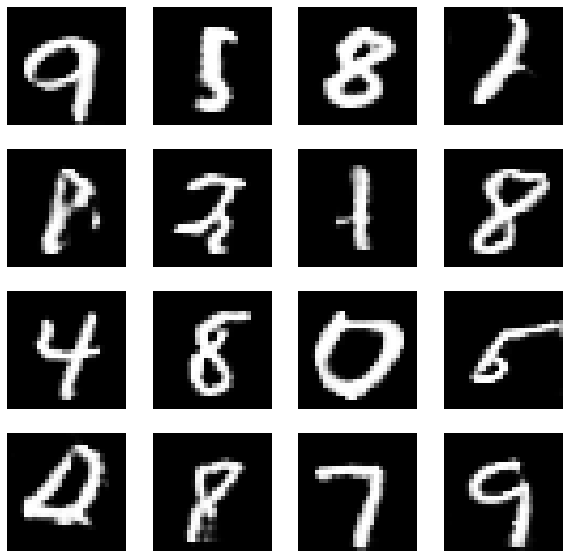

epoch : 9800 생성자 손실 : 1.160 감별자 손실 : 0.601


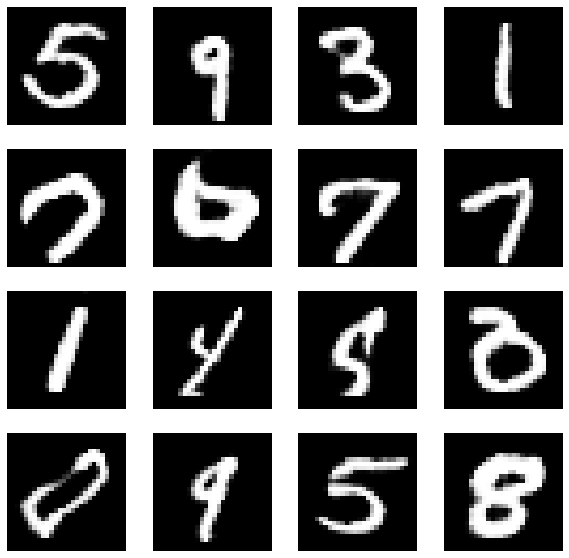

epoch : 9900 생성자 손실 : 1.434 감별자 손실 : 0.542


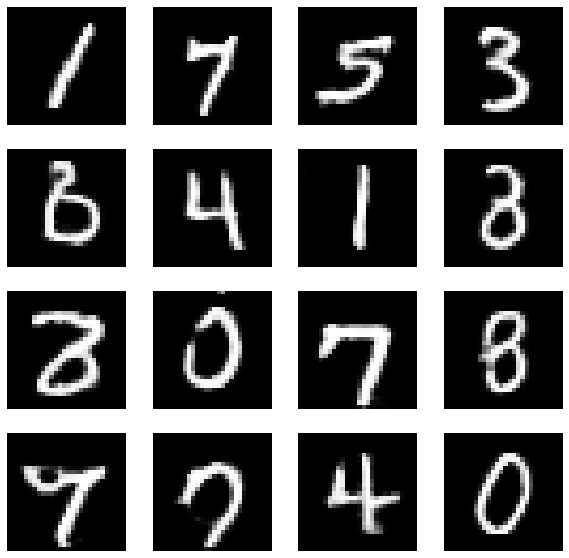

총 학습시간 : 2005.64


In [12]:
# 데이터 처리
X_train = read_data()


# GAN 만들기
generator, discriminator, gan = build_GAN()


# GAN 학습
train_GAN()